# Kaggle Algorithmic Trading Challenge

I thought it would be interesting to analyse the data from this, now closed, 2011 [Kaggle competition](https://www.kaggle.com/c/AlgorithmicTradingChallenge/).

The aim was to develop a model to predict the short term response of a limit-order book to a liquidity shock. A *liquidity shock* is defined as any trade that changes the best bid or ask price. *Liquidity* is a term often used in finance but rarely defined. Generally, it is the ability of a market participant to *quickly* trade *large* amounts of an asset at *low cost*. It has three dimensions: *spread*, *depth* and *resiliency*. Spread represents the transaction cost faced by traders. Depth reflects the market's ability to absorb and execute large orders with minimal price impact. Finally, resiliency is the time dimension. It indicates how quickly the spread and depth of a market recover after a liquidity shock. This occurs when a large trade (or series of smaller trades) consumes all of the available volume at one of the best prices. See [[1]](https://pdfs.semanticscholar.org/0e78/73f3f0ded2d177cb7b5e83b4ce4f9653ea35.pdf) for an example of existing work in this field.

The Kaggle competition was focussed on building an empirical model for the resiliency of the book.

This notebook was developed in AWS using S3 storage and SageMaker. **The cell below should be run to setup all dependencies and you must enter the S3 bucket name that you have associated with your notebook instance.** S3 is used for permanent data storage and your local instance is merely used as temporary storage. Every now and again it is good practice to clean up files in the local instance since it has much less memory.

Everytime an output file is written from this notebook, it is first saved to the local instance and then stored with the same path to S3 using writeLocalToS3(path). Whenever an input file is loaded into this notebook, it is first loaded from S3 into the local instance, using loadS3ToLocal(path), and then loaded into the notebook.

**The following folder structure should first be created in your S3 bucket (this will be replicated in your local instance automatically):**

* **/data**: this is where training and testing data are stored in addition to the various encodings required for different models. Download the competition data set called *training.csv* and store it in this directory under the name *kaggle_data.csv*.

* **/models**: serialised models are stored here with the format *modelName_predict.model*.

* **/predictions**: prediction templates are stored here alongside predictions from each model in the format *modelName_predict.csv*

* **/testing**: errors for each individual price for each prediction are stored here for later analysis in the format *errors_modelName_predict.csv*

In [4]:
#Run this cell to setup dependencies
#MUST FILL IN BUCKETNAME BELOW

import boto3
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import linear_model as lm
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from datetime import datetime
from IPython.display import display

bucketName = "YOUR-BUCKET-NAME"
plt.style.use(['bmh'])
global dataPath_
dataPath_ = "data/"
global predictPath_
predictPath_ = "predictions/"
global modelsPath_
modelsPath_ = "models/"
global testingPath_
testingPath_ = "testing/"
global csvExt_
csvExt_ = ".csv"
global modelExt_
modelExt_ = ".model"

#assumes files are stored the same in s3 bucket as in local instance: same name and directory
def writeLocalToS3(path):
    with open(path,'rb') as f:
        return boto3.Session().resource("s3").Bucket(bucketName).Object(path).upload_fileobj(f)
    
def loadS3ToLocal(path):
    with open(path,'wb') as f:
        return boto3.Session().resource("s3").Bucket(bucketName).Object(path).download_fileobj(f)

## Data

The data provided consisted of 754018 examples of liquidity shocks for 102 different securities on the London Stock Exchange. In the original competition this was all reserved for training; there was a separate testing set to rank model entries. This testing set is no longer available and so the training set will have to be split up into a *test_data* and *train_data*.

In [5]:
kaggleData = "kaggle_data"
kaggleDataPath = dataPath_ + kaggleData + csvExt_

# loadS3ToLocal(kaggleDataPath)
full_data = pd.read_csv(kaggleDataPath)

unique_ids = full_data['security_id'].unique()
print("There are {} liquidity shocks across {} different securities".format(full_data.shape[0], len(unique_ids)))

full_data.head()

There are 754018 liquidity shocks across 102 different securities


,row_id,security_id,p_tcount,p_value,trade_vwap,trade_volume,initiator,transtype1,time1,bid1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
0,1,1,9154,6831386312,2395.0,887,B,Q,08:00:20.799,2225.0,...,2397.0,2399.0,2397.0,2399.0,2397.0,2399.0,2397.0,2398.0,2397.5,2398.0
1,2,1,9154,6831386312,2398.0,748,B,Q,08:00:21.996,2393.0,...,2398.0,2399.0,2398.0,2399.0,2397.0,2399.0,2397.0,2398.0,2397.0,2398.0
2,3,1,9154,6831386312,2398.0,151,B,T,08:00:29.200,2393.0,...,2397.0,2398.0,2397.0,2399.0,2397.0,2399.0,2397.0,2398.0,2397.0,2398.0
3,4,1,9154,6831386312,2398.5,110,S,Q,08:00:31.073,2393.0,...,2397.0,2398.0,2397.0,2398.0,2397.0,2398.0,2397.0,2399.0,2398.0,2399.0
4,5,1,9154,6831386312,2398.0,108,B,T,08:00:31.867,2393.0,...,2398.0,2399.0,2397.0,2399.0,2397.0,2398.0,2397.0,2398.0,2397.0,2398.0


Each row is an example of a liquidity shock and contains 100 events. Events are either trades (when securities are bought or sold and the bid-ask spread instantaneously drops to zero) or quotes (whenever the best bid or ask price is updated). Each row contains many quote events and hence technically many liquidity shocks. However, the main shock under analysis in each row occurs at event 49 with a trade. Event 50 is a quote, and reflects how the book first responds to the shock.

Events 1-50 contain four fields: best bid, best ask, timestamp, transtype (Trade or Quote). Subsequent events (51-100) only contain best bid and best ask. Each row also contains 6 other pieces of information:

* *security_id*: a unique ID for the security
* *p_tcount*: the previous day's number of on-market trades in this security
* *p_value*: the previous day's on-market notional traded in this security (£)
* *trade_vwap*: the volume-weighted average price of the trade causing the liquidity shock (pence)
* *trade_volume*: size of the trade causing the liquidity shock (number of securities)
* *initiator*: whether the shock is buyer (B) or seller (S) initiated

The aim is to predict the events after the liquidity shock (51-100) from all of the information preceding it. The original competition evaluated models by calculating the Root Mean Square Error (RMSE):

$\text{RMSE} = \sqrt{ \frac{1}{N}\sum_{\text{shocks}} \big( \sum_{\text{bids}}(\widehat{b} - b)^2 + \sum_{\text{asks}}(\widehat{a} - a)^2 } \big)$

where $\widehat{b}, \widehat{a}, N$ are an estimated bid, estimated ask and the total number of predictions respectively.

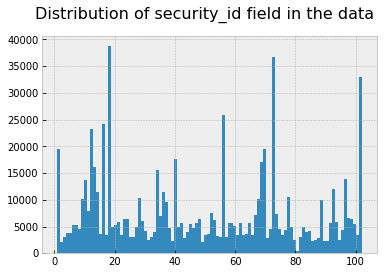

Top 3 securities: [ 18  73 102]
The subset contains 108412 liquidity shocks across 3 different securities


,row_id,security_id,p_tcount,p_value,trade_vwap,trade_volume,initiator,transtype1,time1,bid1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
22479,22480,18,12906,9584789266,431.90,1650,B,Q,08:00:16.805,416.4,...,431.10,433.9,431.10,433.90,431.10,433.90,431.10,433.90,431.10,433.90
22480,22481,18,12906,9584789266,432.85,1462,B,Q,08:00:16.805,416.4,...,432.85,434.0,432.85,434.00,432.85,434.85,432.85,434.90,432.85,434.90
22481,22482,18,12906,9584789266,432.90,266,B,Q,08:00:16.820,430.5,...,432.85,434.9,432.85,434.85,432.85,434.85,432.85,434.90,432.85,434.90
22482,22483,18,12906,9584789266,432.90,10000,B,T,08:00:18.177,430.5,...,432.85,434.9,432.85,435.00,432.85,435.00,432.85,435.00,432.85,435.00
22483,22484,18,12906,9584789266,433.90,10475,B,Q,08:00:18.306,430.5,...,432.90,435.0,432.90,434.95,432.90,434.95,432.90,433.75,432.90,433.75


In [6]:
fig, ax = plt.subplots(1)
full_data['security_id'].hist(bins=102)
fig.suptitle("Distribution of security_id field in the data", fontsize=16)
plt.show()

numSecurities = 3
topSecurities = (np.array(full_data['security_id']
                    .value_counts()
                    .sort_values(ascending=False)
                    .head(numSecurities).axes)).reshape(numSecurities)

print("Top {} securities: {}".format(numSecurities, topSecurities))

subset_data = full_data[full_data['security_id'].isin(topSecurities)]
unique_ids = subset_data['security_id'].unique()

print("The subset contains {} liquidity shocks across {} different securities".format(subset_data.shape[0], len(unique_ids)))

subset_data.head()

The histogram above shows that the 102 different securities are not equally well represented in the data. To reduce the data size down to something more managable for exploration, we focus on just the three most common securities. This still leaves us with 108412 liquidity shocks to analyse.

The competition organisers had a bug in their data collection code that caused event 50 to be identical to event 51 (bid50 = bid51 and ask50 = ask51). For this reason we will drop the two columns corresponding to event 51 from the data. This means that we now only have to predict 49 events: 52-100

In [7]:
subset_data = subset_data.drop('bid51', 1)
subset_data = subset_data.drop('ask51', 1)

subset_data.head()

,row_id,security_id,p_tcount,p_value,trade_vwap,trade_volume,initiator,transtype1,time1,bid1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
22479,22480,18,12906,9584789266,431.90,1650,B,Q,08:00:16.805,416.4,...,431.10,433.9,431.10,433.90,431.10,433.90,431.10,433.90,431.10,433.90
22480,22481,18,12906,9584789266,432.85,1462,B,Q,08:00:16.805,416.4,...,432.85,434.0,432.85,434.00,432.85,434.85,432.85,434.90,432.85,434.90
22481,22482,18,12906,9584789266,432.90,266,B,Q,08:00:16.820,430.5,...,432.85,434.9,432.85,434.85,432.85,434.85,432.85,434.90,432.85,434.90
22482,22483,18,12906,9584789266,432.90,10000,B,T,08:00:18.177,430.5,...,432.85,434.9,432.85,435.00,432.85,435.00,432.85,435.00,432.85,435.00
22483,22484,18,12906,9584789266,433.90,10475,B,Q,08:00:18.306,430.5,...,432.90,435.0,432.90,434.95,432.90,434.95,432.90,433.75,432.90,433.75


The data set will now be split 80%-20% into training and testing data. It will be sampled by security_id to ensure that the distribution of securities in the two data sets are equal. Lastly, the events to be predicted in the test data (52-100) are removed to prevent them from leaking into the prediction data. This means that a model should only ever be exposed to *train_data* and *predict_data* but never *test_data*. The latter contains the test results and is used by a separate service to compute the model's performance.

In [ ]:
trainDataPath = dataPath_ + "train_data" + csvExt_
testDataPath = dataPath_ + "test_data" + csvExt_
predictDataPath = predictPath_ + "predict_data" + csvExt_

stratifyLabel = subset_data['security_id'].values
train_data, test_data = train_test_split(subset_data, test_size=0.2, stratify=stratifyLabel)

train_data.to_csv(trainDataPath, index=False)
writeLocalToS3(trainDataPath)

test_data.to_csv(testDataPath, index=False)
writeLocalToS3(testDataPath)

print("The training data contains {} liquidity shocks".format(train_data.shape[0]))
print("The testing data contains {} liquidity shocks".format(test_data.shape[0]))

columnsToClear = []

for i in range(52,101):
    for column in test_data.columns.values:
        if column.endswith(str(i)) and (column.startswith("bid") or column.startswith("ask")):
            columnsToClear.append(column)
                        
empty_predictions = pd.DataFrame( np.zeros((test_data.shape[0], len(columnsToClear))), index=test_data.index, columns=columnsToClear)
test_data.update(empty_predictions)
                                       
test_data.to_csv(predictDataPath, index=False)
writeLocalToS3(predictDataPath)

test_data.head()

## Exploration

Now we can explore the training data to build up an intuition for the features that might be good predictors of the book after a liquidity shock. The following code was adapted from [[2]](https://github.com/chirag1992m/Algorithmic-Trading-Challenge---Kaggle/blob/master/notebooks/Data_Exploration.ipynb) to illustrate the order book.

In [5]:
def PlotShock(dataPath, row_id):
    
    loadS3ToLocal(dataPath)
    data = pd.read_csv(dataPath)
    
    bid_column_names = []
    ask_column_names = []
    for column in data.columns.values:
        if column.startswith('bid'):
            bid_column_names.append(column)
        elif column.startswith('ask'):
            ask_column_names.append(column)

    event_stamps = range(1,100)
    row = data.loc[ data['row_id']==row_id, : ]
    bid_values = np.array(row[bid_column_names]).flatten('F')
    ask_values = np.array(row[ask_column_names]).flatten('F')

    plt.figure(figsize=(10,8))

    plt.plot(event_stamps, ask_values, label='ask', color='b')
    plt.plot(event_stamps, bid_values, label='bid', color='g')

    x0, x1, y0, y1 = plt.axis()
    plt.axis((x0 - 0.25,
              x1 + 0.25,
              y0 - 0.25,
              y1 + 0.25))

    plt.axvline(x=49, color='r', linestyle='--')

    plt.fill_between(event_stamps, ask_values, ask_values*10, interpolate=True, color='b', alpha=0.3)
    plt.fill_between(event_stamps, 0, bid_values, interpolate=True, color='g', alpha=0.3)

    plt.xlabel("Event No")
    plt.ylabel("Best Prices")

    plt.legend()
    plt.title("Limit Order Book")
    plt.show()

    display(row)

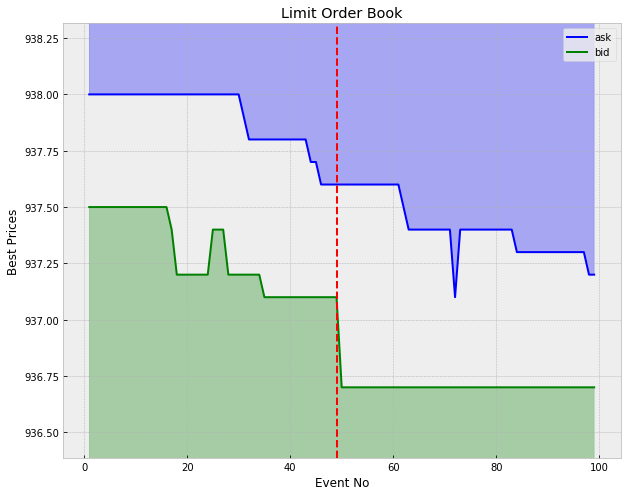

,row_id,security_id,p_tcount,p_value,trade_vwap,trade_volume,initiator,transtype1,time1,bid1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
35839,226374,102,13344,8492047588,937.1,198,S,Q,15:59:15.679,937.5,...,936.7,937.3,936.7,937.3,936.7,937.3,936.7,937.2,936.7,937.2


In [65]:
trainDataPath = dataPath_ + "train_data" + csvExt_
PlotShock(trainDataPath, 226374)

The plot above illustrates the order book for a liquidity shock (row_id = 226374) in security 102. The shock was initiated by a sell trade and hence consumed all of the available volume at the best bid price of around 937.10. This trade decreased the best bid to around 936.70 and hence sharply increased the spread. For the remaining events the best bid stayed constant whilst the best ask steadily dropped until the spread returned approximately to its pre-shock equilibrium value. Note that this by no means always happens and sometimes the shock leaves the book in a new state of equilibrium. In addition, even when the spread does mean-revert it is not always the case that the opposite best price closes the gap: here the best ask could have stayed constant whilst the best bid increased again, or indeed a combination of the two.

## Benchmark Model

The simplest model is to predict constant bid and ask values that are equal to their values just after the shock (bid50 and ask50). We can use this as a benchmark on which to build more complexity.

In [66]:
def BenchmarkPredict():
    
    predictTemplatePath = predictPath_ + "prediction_data" + csvExt_
    modelPredictPath = predictPath_ + "benchmark_predict" + csvExt_
    
    loadS3ToLocal(predictTemplatePath)
    prediction_data = pd.read_csv(predictTemplatePath)
    
    bidColumnsToUpdate = []
    askColumnsToUpdate = []

    for i in range(52,101):
        for column in prediction_data.columns.values:
            if column.endswith(str(i)):
                if column.startswith('bid'):
                    bidColumnsToUpdate.append(column)
                if column.startswith('ask'):
                    askColumnsToUpdate.append(column)
                    
    #for each liquidity shock
    for ix, row in prediction_data.iterrows():
        
        constBid = row['bid50']
        constAsk = row['ask50']
        
        #for each post-liquidity prediction
        for bidColumn in bidColumnsToUpdate:
            prediction_data.set_value(ix, bidColumn, constBid)
        for askColumn in askColumnsToUpdate:
            prediction_data.set_value(ix, askColumn, constAsk)
    
    prediction_data.to_csv(modelPredictPath, index=False)
    writeLocalToS3(modelPredictPath)
    
    display(prediction_data.head())

In [67]:
BenchmarkPredict()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:28: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:30: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,row_id,security_id,p_tcount,p_value,trade_vwap,trade_volume,initiator,transtype1,time1,bid1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
0,439495,73,16239,13909320205,3061.00,709,S,Q,14:01:44.197,3057.0,...,3060.5,3062.0,3060.5,3062.0,3060.5,3062.0,3060.5,3062.0,3060.5,3062.0
1,82233,73,11552,10986877436,3293.00,109,S,Q,15:16:30.978,3294.0,...,3292.0,3293.5,3292.0,3293.5,3292.0,3293.5,3292.0,3293.5,3292.0,3293.5
2,677727,73,19304,14603738564,3314.00,168,B,Q,14:42:39.385,3313.5,...,3313.0,3314.5,3313.0,3314.5,3313.0,3314.5,3313.0,3314.5,3313.0,3314.5
3,339465,102,17510,11402659276,953.70,703,B,T,08:33:26.433,953.5,...,953.2,953.8,953.2,953.8,953.2,953.8,953.2,953.8,953.2,953.8
4,620065,18,25053,23715372270,459.25,2009,S,Q,16:12:27.546,459.3,...,459.1,459.3,459.1,459.3,459.1,459.3,459.1,459.3,459.1,459.3


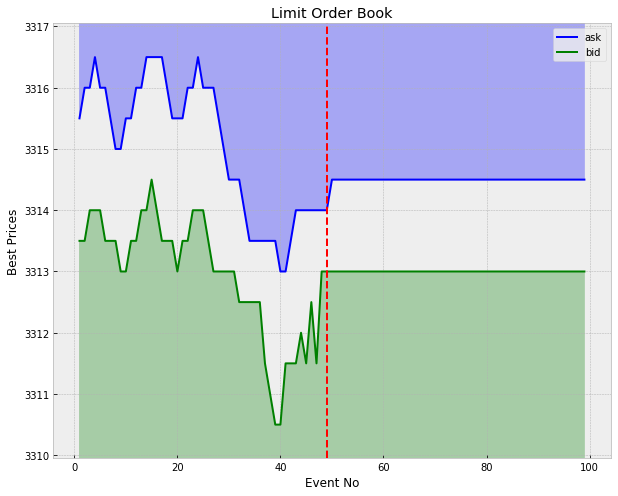

,row_id,security_id,p_tcount,p_value,trade_vwap,trade_volume,initiator,transtype1,time1,bid1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
2,677727,73,19304,14603738564,3314.0,168,B,Q,14:42:39.385,3313.5,...,3313.0,3314.5,3313.0,3314.5,3313.0,3314.5,3313.0,3314.5,3313.0,3314.5


In [68]:
benchmarkPredictPath = predictPath_ + "benchmark_predict" + csvExt_
PlotShock(benchmarkPredictPath, 677727)

The plot above illustrates this simple model for a particular liquidity shock.

In [7]:
def RMSE( predictionData ):
    
    predictionDataPath = predictPath_ + predictionData
    testDataPath = dataPath_ + "test_data" + csvExt_
    predictTemplatePath = predictPath_ + "prediction_data" + csvExt_
    errorsPath = testingPath_ + "errors_" + predictionData
    
    loadS3ToLocal(predictionDataPath)
    prediction_data = pd.read_csv(predictionDataPath)
    
    loadS3ToLocal(testDataPath)
    results_data = pd.read_csv(testDataPath)
    
    loadS3ToLocal(predictTemplatePath)
    square_errors_data = pd.read_csv(predictTemplatePath)
    
    columnsToTest = []

    for i in range(52,101):
        for column in prediction_data.columns.values:
            if (column.endswith(str(i)) and (column.startswith("bid") or column.startswith("ask"))):
                columnsToTest.append(column)
                
    numPredictionsPerShock = len(columnsToTest)
    totalPredictions = numPredictionsPerShock * prediction_data.shape[0]
    sumSquaredErrors = 0.0
    
    #for each liquidity shock
    for ix, row in prediction_data.iterrows():
        
        print("Evaluating row: {}/{}".format(ix+1, prediction_data.shape[0]))
        
        row_id = row['row_id']

        predictedRow = prediction_data.loc[ prediction_data['row_id']==row_id, columnsToTest ]
        actualRow = results_data.loc[ results_data['row_id']==row_id, columnsToTest ]
        squareErrors = (predictedRow - actualRow)**2
        square_errors_data.loc[results_data['row_id']==row_id, columnsToTest] = squareErrors
        sumSquaredErrors += squareErrors.sum(axis=1).values[0]
    
    RMSE = np.sqrt( sumSquaredErrors / totalPredictions )
    
    square_errors_data.to_csv(errorsPath, index=False)
    writeLocalToS3(errorsPath)
    
    print("RMSE: {}".format(RMSE))

In [ ]:
RMSE("benchmark_predict.csv")

Running the RMSE() validation function above returns a score of 1.09998.

In [10]:
def PlotErrorsAgainstEvent( errorsData ):
    
    errorDataPath = testingPath_ + errorsData
    
    loadS3ToLocal(errorDataPath)
    errors_data = pd.read_csv( errorDataPath )

    bidColumns = []
    askColumns = []
    bidMeanSquareErrors = []
    askMeanSquareErrors = []

    for i in range(52,101):
        for column in errors_data.columns.values:
            if column.endswith(str(i)):
                if column.startswith('bid'):
                    bidColumns.append(column)
                if column.startswith('ask'):
                    askColumns.append(column)

    for column in bidColumns:
        bidMeanSquareErrors.append( errors_data.loc[:, column].mean() )

    for column in askColumns:
        askMeanSquareErrors.append( errors_data.loc[:, column].mean() )

    meanSquareErrors = np.array(bidMeanSquareErrors) + np.array(askMeanSquareErrors)

    predictionEvents = range(52, 101)
    plt.plot(predictionEvents, meanSquareErrors)
    
    plt.xlabel("Event No")
    plt.ylabel("Average Square Error")

    plt.title("A plot showing average square error as a function of time after the liquidity shock")
    plt.show()

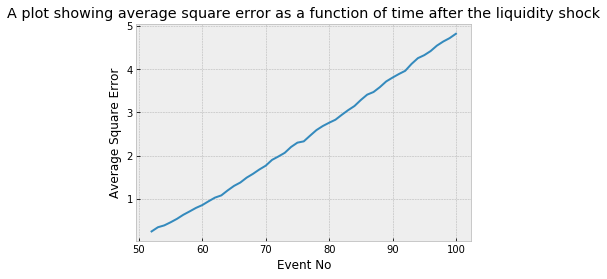

In [84]:
PlotErrorsAgainstEvent("errors_benchmark_predict.csv")

Though perhaps intuitive, the plot above highlights that the predictive power of our model decreases the further we move from the liquidity shock. The near perfect linearity is a surprise though. The average square error can be thought of as the variance of the security price after the shock, hence the standard deviation grows approximately like the square-root-of time: evidence of an underlying Geometric Brownian process.

In [85]:
def PlotErrorsAgainstPrice( errorsData ):
    
    errorDataPath = testingPath_ + errorsData
    
    loadS3ToLocal(errorDataPath)
    errors_data = pd.read_csv( errorDataPath )
    
    securityToFairPrices = {18:[], 73:[], 102:[]}
    securityToMeanSquareErrors = {18:[], 73:[], 102:[]}
    securityToColor = {18:'red', 73:'green', 102:'blue'}

    columnsToTest = []
    for i in range(52,101):
        for column in errors_data.columns.values:
            if (column.endswith(str(i)) and (column.startswith("bid") or column.startswith("ask"))):
                columnsToTest.append(column)

    for ix, row in errors_data.iterrows():
        security = row['security_id']
        fairPrice = (row['bid1'] + row['ask1'])/2
        securityToFairPrices[security].append(fairPrice)
        squareErrors = row.loc[columnsToTest]
        securityToMeanSquareErrors[security].append( squareErrors.mean() )

    fig, ax = plt.subplots()

    for security, fairPrices in securityToFairPrices.items():
        ax.scatter(fairPrices, securityToMeanSquareErrors[security], c=securityToColor[security], label=security)

    ax.legend()
    ax.set_xlabel("Initial Fair Price")
    ax.set_ylabel("Average Square Error")
    plt.title("A plot showing average square error as a function of initial fair price for each security considered.")
    plt.show()

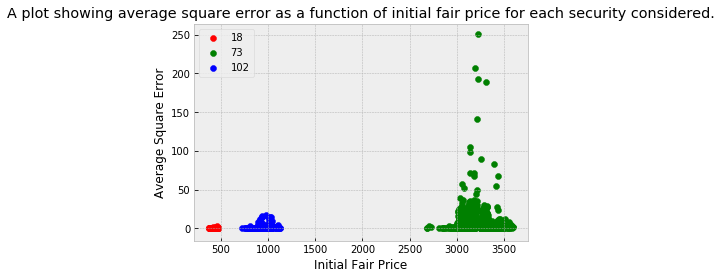

In [86]:
PlotErrorsAgainstPrice("errors_benchmark_predict.csv")

Each of the three securities considered trade within different price ranges: 18 being the lowest and 73 being the highest. The plot above illustrates that the error is worse for securities that trade at a higher price. This is perhaps not surprising due to the chosen error metric (RMSE). It is clear that a handful of security 73 liquidity shocks contribute significantly to the overall error score. An error metric as a fraction of fair price might have removed this effect.

In [87]:
def PlotErrorsAgainstTime( errorsData ):
    
    errorDataPath = testingPath_ + errorsData
    
    loadS3ToLocal(errorDataPath)
    errors_data = pd.read_csv( errorDataPath )

    securityToShockTimes = {73:[], 102:[], 18:[]}
    securityToMeanSquareErrors = {73:[], 102:[], 18:[]}
    securityToColor = {18:'red', 73:'green', 102:'blue'}
    timeFormat = "%H:%M:%S.%f"
    marketOpen = "08:00:00.0"
    openDateTime = datetime.strptime(marketOpen, timeFormat)
    marketClose = "16:30:00.0"
    closeDateTime = datetime.strptime(marketClose, timeFormat)
    hours = mdates.HourLocator(interval = 1)
    h_fmt = mdates.DateFormatter('%H')

    columnsToTest = []
    for i in range(52,101):
        for column in errors_data.columns.values:
            if (column.endswith(str(i)) and (column.startswith("bid") or column.startswith("ask"))):
                columnsToTest.append(column)

    for ix, row in errors_data.iterrows():
        security = row['security_id']
        shockTime = datetime.strptime(row['time50'], timeFormat)
        securityToShockTimes[security].append( shockTime )
        squareErrors = row.loc[columnsToTest]
        securityToMeanSquareErrors[security].append( squareErrors.mean() )

    fig, ax = plt.subplots()

    for security, shockTimes in securityToShockTimes.items():
        ax.scatter(shockTimes, securityToMeanSquareErrors[security],
                   c=securityToColor[security], label=security, alpha=0.3)

    ax.legend()
    ax.set_xlim(openDateTime, closeDateTime)
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(h_fmt)
    ax.set_xlabel("Time of Liquidity Shock")
    ax.set_ylabel("Average Square Error")
    plt.title("A plot showing average square error as a function of shock time.")
    plt.show()

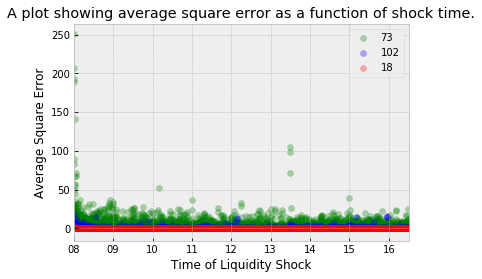

In [88]:
PlotErrorsAgainstTime("errors_benchmark_predict.csv")

The plot above illustrates that errors are not uniformly distributed across the trading day. The market open is a particularly volatile time, causing our model to perform worse. There is also another peak around 13:30 UK time, which correponds to 08:30 NYC when the New York Stock Exchange opens.

In conjunction with the previous plot, we can see that the handful of liquidity shocks that contribute substantially to our total error are all security 73 occuring mostly near the market open. This is caused by a combination of the chosen error metric (penalising higher priced securities) and our model performing poorly in volatile market conditions.

## Regression Algorithms

The next simplest approach is to train a regression model on the features provided (p_tcount, p_value, trade_vwap, trade_volume, initiator) and the bid-ask prices and transtype prior to the shock (1-50) in order to solely predict bid52/ask52 after the shock, assuming constant prices thereafter.

Two of the properties (initiator and transtype) contain categorical data that must be encoded into numerical values for our models to consume. Each property will be replaced by a binary classifier for each row: is_seller and transtype_is_Q respectively. The *train_data* and *prediction_data* need to be updated with this encoding, but not the *test_data*. This file is only used to read in results.

In [96]:
def encodeData():
    trainPath = [dataPath_,"train_data" + csvExt_]
    predictionPath = [predictPath_,"prediction_data" + csvExt_]

    paths = [trainPath, predictionPath]
    
    for path in paths:
        
        print("Loading: " + path[0] + path[1])
        
        loadS3ToLocal(path[0] + path[1])
        data = pd.read_csv(path[0] + path[1])
        
        print("Encoding...")
        index = data.columns.get_loc('initiator')
        data.insert(index+1, 'is_seller', 0)
        data['is_seller'] = data['initiator'].apply(lambda x: 1 if x == 'S' else 0)
        data = data.drop('initiator', 1)
        
        #for each transtype column
        for i in range(1, 51):
            column_name = 'transtype' + str(i)
            new_column_name_Q = 'transtype' + str(i) + '_is_Q'

            index = data.columns.get_loc(column_name)
            data.insert(index+1, new_column_name_Q, 0)

            data[new_column_name_Q] = data[column_name].apply(lambda x: +1 if x == 'Q' else 0)

            #drop the initial column itself
            data = data.drop(column_name, 1)
        
        print("Encoding completed:")
        display(data.head())
        
        print("Saving data...\n")
        data.to_csv(path[0] + "encoded_" + path[1], index=False)
        writeLocalToS3(path[0] + "encoded_" + path[1])

In [97]:
encodeData()

Loading: data/train_data.csv
Encoding...
Encoding completed:


,row_id,security_id,p_tcount,p_value,trade_vwap,trade_volume,is_seller,transtype1_is_Q,time1,bid1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
0,557262,73,17916,16972338272,3065.50,32,1,0,09:33:43.936,3068.50,...,3065.50,3067.50,3065.50,3066.5,3065.50,3066.50,3065.50,3066.50,3065.50,3067.00
1,616724,18,25053,23715372270,458.55,958,1,1,13:17:19.120,458.45,...,458.35,458.45,458.35,458.5,458.35,458.45,458.35,458.50,458.35,458.45
2,312426,73,21293,20760468802,3172.50,7,1,0,12:08:40.137,3174.00,...,3169.00,3171.00,3169.00,3171.5,3169.00,3171.50,3169.00,3171.50,3169.50,3171.50
3,728848,18,11290,8379895754,405.40,4195,0,1,09:00:25.637,405.40,...,405.25,405.60,405.25,405.6,405.25,405.60,405.25,405.55,405.30,405.55
4,559656,73,17916,16972338272,3128.50,32,1,1,14:20:30.331,3127.00,...,3129.00,3130.50,3129.50,3130.5,3129.50,3130.50,3129.00,3130.50,3128.50,3130.50


Saving data...

Loading: predictions/prediction_data.csv
Encoding...
Encoding completed:


,row_id,security_id,p_tcount,p_value,trade_vwap,trade_volume,is_seller,transtype1_is_Q,time1,bid1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
0,439495,73,16239,13909320205,3061.00,709,1,1,14:01:44.197,3057.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,82233,73,11552,10986877436,3293.00,109,1,1,15:16:30.978,3294.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,677727,73,19304,14603738564,3314.00,168,0,1,14:42:39.385,3313.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,339465,102,17510,11402659276,953.70,703,0,0,08:33:26.433,953.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,620065,18,25053,23715372270,459.25,2009,1,1,16:12:27.546,459.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Saving data...



### Linear Regression

We will start with a basic multivariate linear regression and build two models: one to predict bid52 and another for ask52. This makes intuitive sense since we have seen that the bid and ask behave differently after a liquidity shock. Each model will be trained on all of the features (bid and ask). The data will be normalised so that the coefficients can be easily analysed later.

In [17]:
def setupBATrainingData(train_data):
    
    bidPredictionColumns = []
    for i in range(52, 101):
        for column in train_data.columns.values:
            if column.endswith(str(i)) and column.startswith('bid'):
                bidPredictionColumns.append(column)

    askPredictionColumns = []
    for i in range(52, 101):
        for column in train_data.columns.values:
            if column.endswith(str(i)) and column.startswith('ask'):
                askPredictionColumns.append(column)

    predictionColumns = bidPredictionColumns + askPredictionColumns
    
    featureColumns = []
    for column in train_data.columns.values:
        if ((column not in predictionColumns) and (column != 'row_id') and (column != 'security_id') and (not column.startswith('time'))):
            featureColumns.append(column)
            
    #fill in training input (X) and output (Y) data for both Ask/Bid models
    trainX = np.zeros((train_data.shape[0], len(featureColumns) ))
    trainY_bid = np.zeros((train_data.shape[0]))
    trainY_ask = np.zeros((train_data.shape[0]))
    
    for ix, row in train_data.iterrows():
        X = (np.array(row[featureColumns])).flatten('F')
        
        #pick out bid52 & ask52
        Y_bid = row[bidPredictionColumns[0]]
        Y_ask = row[askPredictionColumns[0]]

        trainX[ix, :] = X
        trainY_bid[ix] = Y_bid
        trainY_ask[ix] = Y_ask
        
    return [featureColumns, predictionColumns, trainX, trainY_bid, trainY_ask]
    
def LinearRegPredict():

    print("Setting up...")
    
    trainDataPath = dataPath_ + "encoded_train_data" + csvExt_
    predictTemplatePath = predictPath_ + "encoded_prediction_data" + csvExt_
    modelPath = modelsPath_ + "linearReg_predict" + modelExt_
    modelPredictPath = predictPath_ + "linearReg_predict" + csvExt_
    
    loadS3ToLocal(trainDataPath)
    train_data = pd.read_csv(trainDataPath)
    
    loadS3ToLocal(predictTemplatePath)
    prediction_data = pd.read_csv(predictTemplatePath)
    
    [featureColumns, predictionColumns, trainX, trainY_bid, trainY_ask] = setupBATrainingData(train_data)

    print("Fitting models...")
    
    LR_model_bid = lm.LinearRegression(fit_intercept=True, normalize=True)
    LR_model_bid.fit(trainX, trainY_bid)
    
    LR_model_ask = lm.LinearRegression(fit_intercept=True, normalize=True)
    LR_model_ask.fit(trainX, trainY_ask)    
        
    print("Saving models...")
    model = [LR_model_bid, LR_model_ask]
    pickle.dump(model, open(modelPath, 'wb'))
    writeLocalToS3(modelPath)
    
    print("Predicting...")
    
    #fill in predict input (X)
    predictX = np.zeros((prediction_data.shape[0], len(featureColumns) ))
    for ix, row in prediction_data.iterrows():
        X = (np.array(row[featureColumns])).flatten('F')
        predictX[ix, :] = X

    predictY_bid = LR_model_bid.predict(predictX)
    predictY_ask = LR_model_ask.predict(predictX)
    
    for ix, row in prediction_data.iterrows():
        bid = predictY_bid[ix]
        ask = predictY_ask[ix]

        for column in predictionColumns:
            if column.startswith('bid'):
                prediction_data.set_value(ix, column, bid)
            else:
                prediction_data.set_value(ix, column, ask)
                
    print("Saving predictions...")
    prediction_data.to_csv(modelPredictPath, index=False)
    writeLocalToS3(modelPredictPath)
    
    display(prediction_data.head())

In [92]:
LinearRegPredict()

Setting up...
Fitting models...
Saving models...
Predicting...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:87: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:89: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Saving predictions...


,row_id,security_id,p_tcount,p_value,trade_vwap,trade_volume,is_seller,transtype1_is_Q,time1,bid1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
0,439495,73,16239,13909320205,3061.00,709,1,1,14:01:44.197,3057.0,...,3060.486724,3061.853739,3060.486724,3061.853739,3060.486724,3061.853739,3060.486724,3061.853739,3060.486724,3061.853739
1,82233,73,11552,10986877436,3293.00,109,1,1,15:16:30.978,3294.0,...,3292.052838,3293.417862,3292.052838,3293.417862,3292.052838,3293.417862,3292.052838,3293.417862,3292.052838,3293.417862
2,677727,73,19304,14603738564,3314.00,168,0,1,14:42:39.385,3313.5,...,3313.103240,3314.621527,3313.103240,3314.621527,3313.103240,3314.621527,3313.103240,3314.621527,3313.103240,3314.621527
3,339465,102,17510,11402659276,953.70,703,0,0,08:33:26.433,953.5,...,953.310986,953.760906,953.310986,953.760906,953.310986,953.760906,953.310986,953.760906,953.310986,953.760906
4,620065,18,25053,23715372270,459.25,2009,1,1,16:12:27.546,459.3,...,459.150272,459.262709,459.150272,459.262709,459.150272,459.262709,459.150272,459.262709,459.150272,459.262709


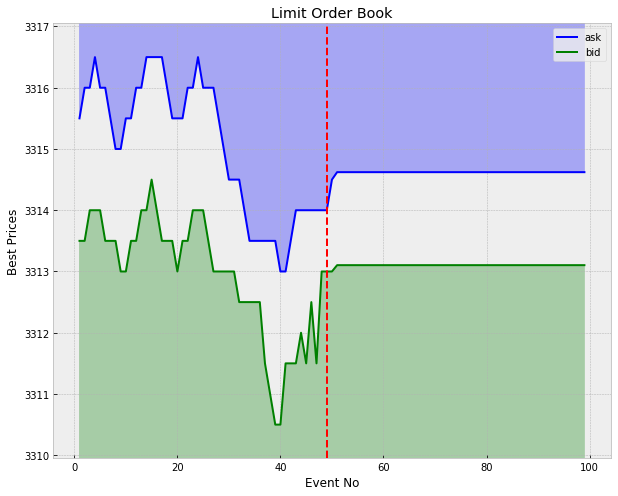

,row_id,security_id,p_tcount,p_value,trade_vwap,trade_volume,is_seller,transtype1_is_Q,time1,bid1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
2,677727,73,19304,14603738564,3314.0,168,0,1,14:42:39.385,3313.5,...,3313.10324,3314.621527,3313.10324,3314.621527,3313.10324,3314.621527,3313.10324,3314.621527,3313.10324,3314.621527


In [98]:
linearRegPredictPath = predictPath_ + "linearReg_predict" + csvExt_
PlotShock(linearRegPredictPath, 677727)

In [ ]:
RMSE("linearReg_predict.csv")

The plot above illustrates the small upward adjustment predicted by the linear model just after the shock (bid52/ask52), continued by a constant price thereafter. Running the RMSE() validation function above returns a score of 1.06442, beating the benchmark model.

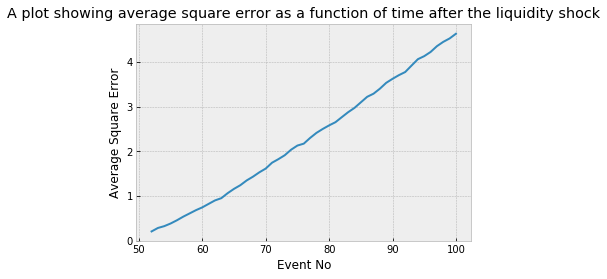

In [101]:
PlotErrorsAgainstEvent("errors_linearReg_predict.csv")

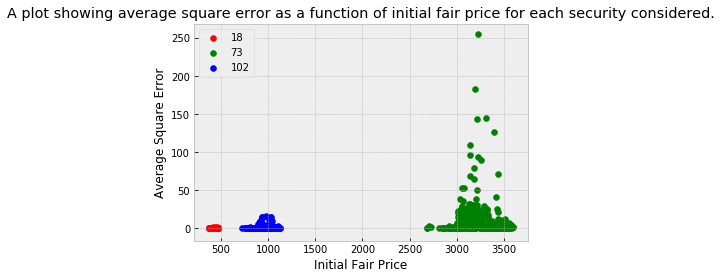

In [102]:
PlotErrorsAgainstPrice("errors_linearReg_predict.csv")

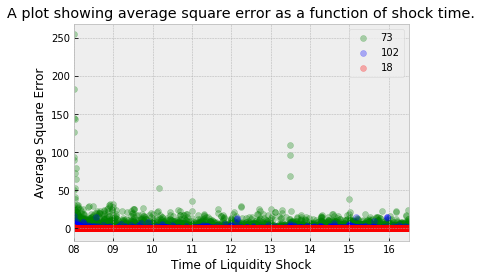

In [103]:
PlotErrorsAgainstTime("errors_linearReg_predict.csv")

The three plots above very much resemble the error analysis performed for the benchmark model.

In [20]:
def PlotBALinearCoefficients( model_name ):

    modelPath = modelsPath_ + model_name + modelExt_
    predictTemplatePath = predictPath_ + "encoded_prediction_data" + csvExt_
    
    loadS3ToLocal(modelPath)
    [bidModel, askModel] = pickle.load(open(modelPath, 'rb'))
    models = {model_name + " Bid": bidModel, model_name + " Ask": askModel}

    loadS3ToLocal(predictTemplatePath)
    prediction_data = pd.read_csv(predictTemplatePath)

    predictionColumns = []
    for i in range(52, 101):
        for column in prediction_data.columns.values:
            if column.endswith(str(i)) and (column.startswith("bid") or column.startswith("ask")):
                predictionColumns.append(column)

    featureColumns = []
    for column in prediction_data.columns.values:
        if ((column not in predictionColumns) and (column != 'row_id') and (column != 'security_id') and (not column.startswith('time'))):
            featureColumns.append(column)

    #plot the liquidity trade properties coefficients
    for name, model in models.items():
        coeffs = model.coef_
        propertyCoeffs = list(coeffs[0:5])
        propertyLabels = featureColumns[0:5]        

        fig, axis = plt.subplots(1, 1, figsize=(8, 5))
        axis.bar(propertyLabels, propertyCoeffs)
        axis.set_ylabel("coefficients")
        plt.title("A bar chart illustrating feature coefficients for the " + name + " model.")
        plt.show()

    # plot transtype coefficients    
    for name, model in models.items():  
        coeffs = model.coef_
        transCoeffs = [coeffs[i] for i in range(len(featureColumns)) if featureColumns[i].startswith("trans")]

        fig, axis = plt.subplots(1, 1, figsize=(20, 5))
        axis.bar(range(1,51), transCoeffs)
        axis.set_ylabel("coefficients")
        plt.title("A bar chart illustrating the transaction type (is_Quote) coefficients for the " + name + " model." )
        plt.show()

    #plot price coefficients
    for name, model in models.items():  
        coeffs = model.coef_
        priceCoeffs = [coeffs[i] for i in range(len(featureColumns)) if (featureColumns[i].startswith("bid") or featureColumns[i].startswith("ask"))]

        fig, axis = plt.subplots(1, 1, figsize=(20, 5))
        axis.bar(range(100), priceCoeffs)
        axis.tick_params(bottom=False, labelbottom=False) 
        axis.set_ylabel("coefficients")
        plt.title("A bar chart illustrating the price coefficients in (Bid, Ask) pairs for the " + name + " model." )
        plt.show()
    

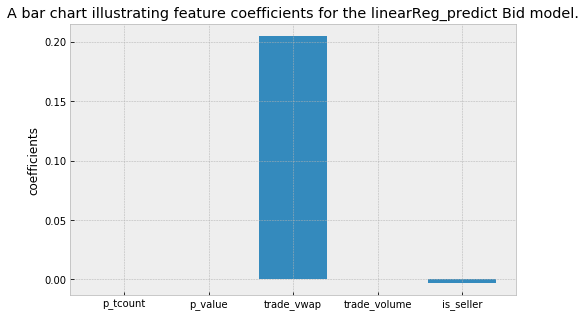

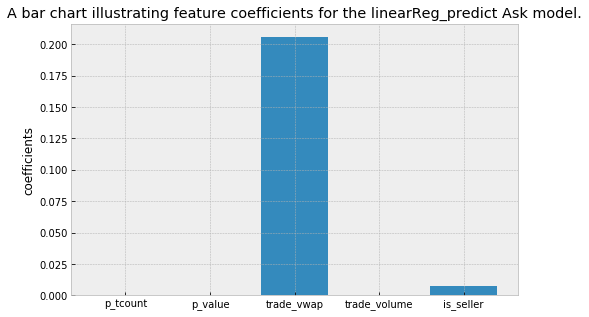

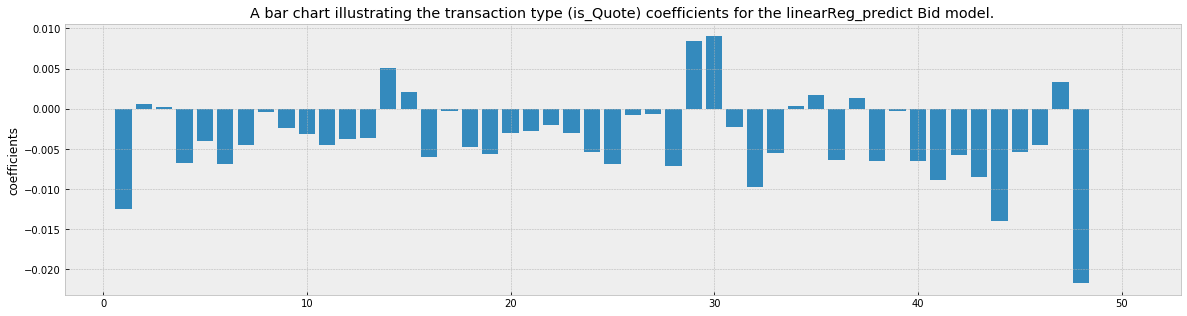

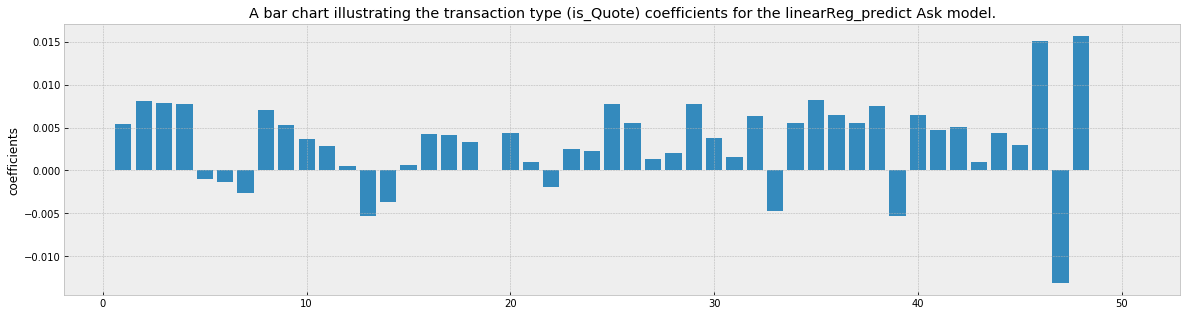

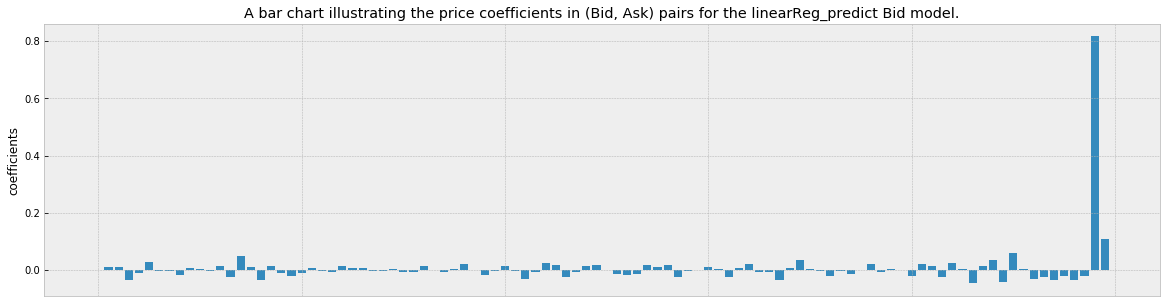

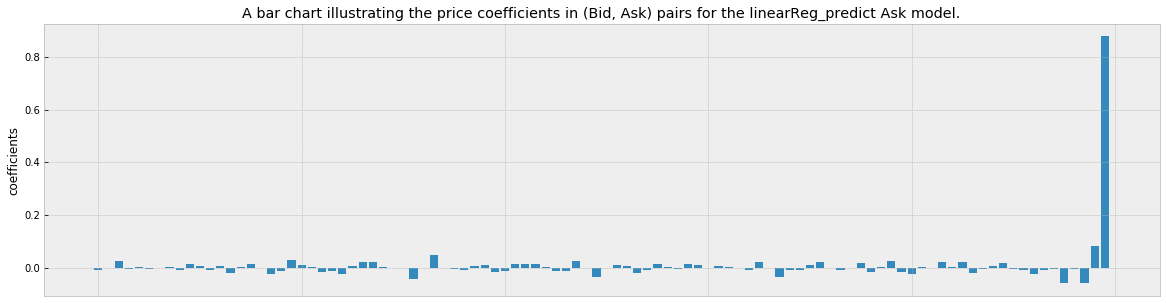

In [106]:
PlotBALinearCoefficients( "linearReg_predict" )

The plots above illustrate the learned coefficients of the two linear models (bid and ask).

Both models utilise the initial features very similarly: mostly exploiting trade_vwap but also adding some weight to is_seller. It is intuitive that trade_vwap (the volume-weighted average price of the trade causing the shock) should contain information regarding the book just after the shock.

Both models add some emphasis to the transaction type (is_Quote) of events before the shock. They each add zero weight to transtype50_is_Q and transtype49_is_Q, since they are 1 and 0 respectively, indiscriminately for all rows. Intuitively both models consider the feature next closest to the shock (transtype48_is_Q) to be the most important in terms of absolute coefficient. However, these coefficients are all an order of magnitude smaller than those attributed to trade_vwap.

Both models consider there to be almost no useful information within prices 1-49, only adding non-trivial weight to the event closest to the shock. Intuitively, for the last event the bid model weights bid50 over ask50, whilst the ask model behaves in the reverse. Both models consider their respective final price to be the most important feature, attributing a coefficient that is approximately four times that for trade_vwap.

### Linear Regression with L1 Regularisation

The Gauss-Markov Theorem tells us that Ordinary Least Squares (OLS) regression produces the best (lowest variance), unbiased estimates for linear model coefficients, $\boldsymbol{\beta}$, so long as errors are mutually uncorrelated and homoscedastic.

Of course in practise these caveats will not hold exactly, especially if the features are correlated, in which case standard OLS regression can produce high-variance coefficient estimates that are overfit to the training data. L1 or LASSO (Least Absolute Shrinkage and Selection Operator) Regularisation adds a constraint to the objective function that insists the L1 norm of the model coefficients, $|\boldsymbol{\beta}|_1 = \sum{|\beta_i|}$, is less than some fixed, specified amount. Using Lagrange multipliers, this modifies the objective function:

$\min_{\boldsymbol{\beta}}\big(|\boldsymbol{Y - X\beta}|_2^2 + \lambda|\boldsymbol{\beta}|_1\big)$

where $\lambda$ is a fixed constant that determines how much the optimisation should penalise large coefficients. This model hyperparameter can be selected using a simple grid-search.

L1 Regularisation has a Bayesian interpretation and is equivalent to assigning the coefficients Laplace prior distributions. Note that in penalising large coefficients, this method often produces sparse solutions where many of the coefficients are zero. This can be considered in-built feature selection.

In [15]:
def LinearLassoPredict():

    print("Setting up...")
    
    trainDataPath = dataPath_ + "encoded_train_data" + csvExt_
    predictTemplatePath = predictPath_ + "encoded_prediction_data" + csvExt_
    modelPath = modelsPath_ + "linearLasso_predict" + modelExt_
    modelPredictPath = predictPath_ + "linearLasso_predict" + csvExt_
    
    loadS3ToLocal(trainDataPath)
    train_data = pd.read_csv(trainDataPath)
    
    loadS3ToLocal(predictTemplatePath)
    prediction_data = pd.read_csv(predictTemplatePath)
    
    [featureColumns, predictionColumns, trainX, trainY_bid, trainY_ask] = setupBATrainingData(train_data)

    print("Fitting models...")
    
    LR_model_bid = lm.Lasso(alpha=0.0001, fit_intercept=True, normalize=True)
    LR_model_bid.fit(trainX, trainY_bid)
    
    LR_model_ask = lm.Lasso(alpha=0.0001, fit_intercept=True, normalize=True)
    LR_model_ask.fit(trainX, trainY_ask)    
        
    print("Saving models...")
    model = [LR_model_bid, LR_model_ask]
    pickle.dump(model, open(modelPath, 'wb'))
    writeLocalToS3(modelPath)
    
    print("Predicting...")
    
    #fill in predict input (X)
    predictX = np.zeros((prediction_data.shape[0], len(featureColumns) ))
    for ix, row in prediction_data.iterrows():
        X = (np.array(row[featureColumns])).flatten('F')
        predictX[ix, :] = X

    predictY_bid = LR_model_bid.predict(predictX)
    predictY_ask = LR_model_ask.predict(predictX)
    
    for ix, row in prediction_data.iterrows():
        bid = predictY_bid[ix]
        ask = predictY_ask[ix]

        for column in predictionColumns:
            if column.startswith('bid'):
                prediction_data.set_value(ix, column, bid)
            else:
                prediction_data.set_value(ix, column, ask)
                
    print("Saving predictions...")
    prediction_data.to_csv(modelPredictPath, index=False)
    writeLocalToS3(modelPredictPath)
    
    display(prediction_data.head())

In [18]:
LinearLassoPredict()

Setting up...
Fitting models...
Saving models...
Predicting...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:48: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:50: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Saving predictions...


,row_id,security_id,p_tcount,p_value,trade_vwap,trade_volume,is_seller,transtype1_is_Q,time1,bid1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
0,439495,73,16239,13909320205,3061.00,709,1,1,14:01:44.197,3057.0,...,3060.170115,3061.894834,3060.170115,3061.894834,3060.170115,3061.894834,3060.170115,3061.894834,3060.170115,3061.894834
1,82233,73,11552,10986877436,3293.00,109,1,1,15:16:30.978,3294.0,...,3292.346108,3294.181253,3292.346108,3294.181253,3292.346108,3294.181253,3292.346108,3294.181253,3292.346108,3294.181253
2,677727,73,19304,14603738564,3314.00,168,0,1,14:42:39.385,3313.5,...,3312.692775,3314.608340,3312.692775,3314.608340,3312.692775,3314.608340,3312.692775,3314.608340,3312.692775,3314.608340
3,339465,102,17510,11402659276,953.70,703,0,0,08:33:26.433,953.5,...,953.153415,953.794734,953.153415,953.794734,953.153415,953.794734,953.153415,953.794734,953.153415,953.794734
4,620065,18,25053,23715372270,459.25,2009,1,1,16:12:27.546,459.3,...,459.278179,459.418996,459.278179,459.418996,459.278179,459.418996,459.278179,459.418996,459.278179,459.418996


The function linearLassoPredict() above trains a linear regression model with L1 regularisation using the rather arbitrary value $\lambda=0.0001$.

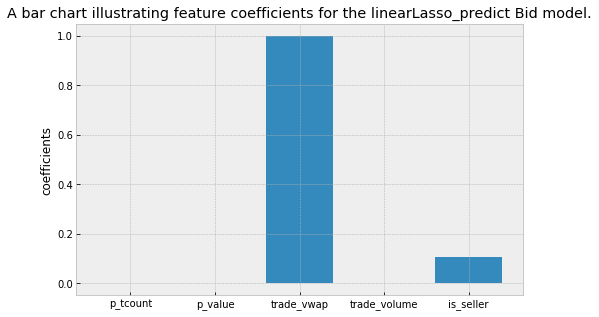

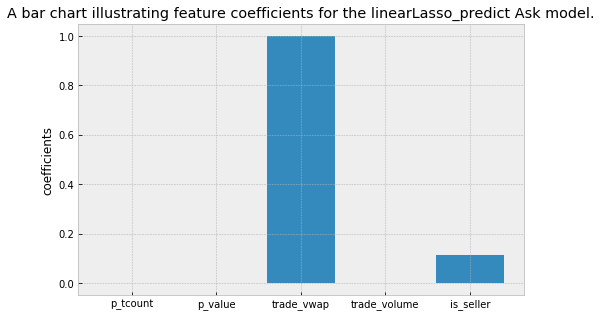

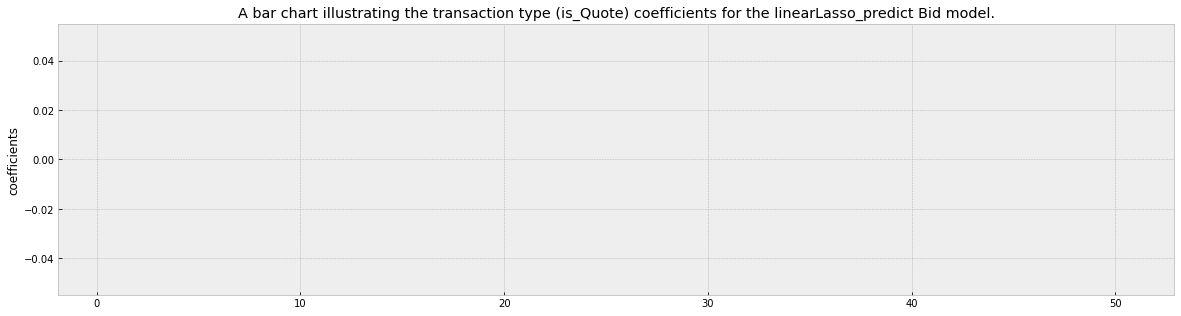

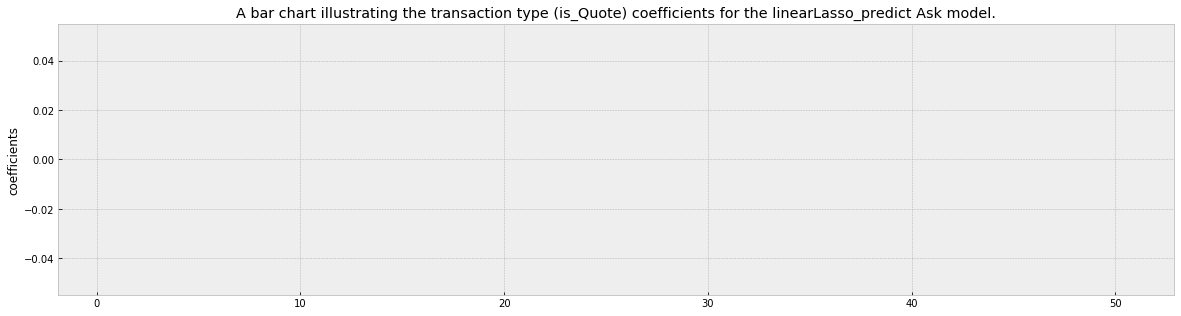

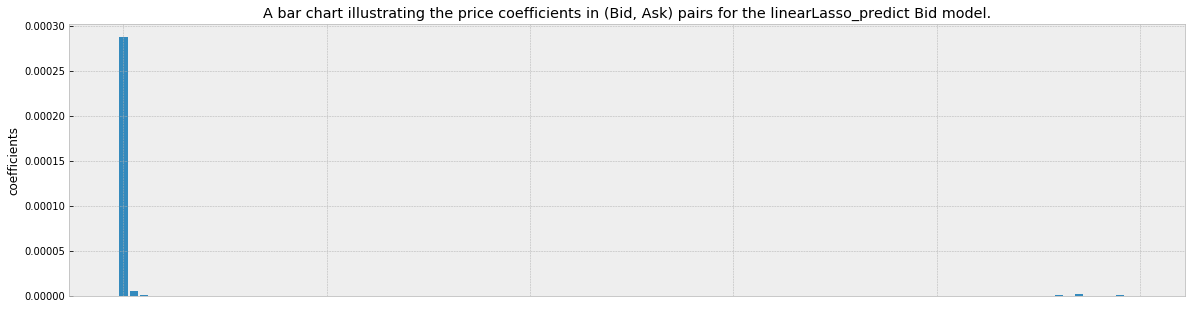

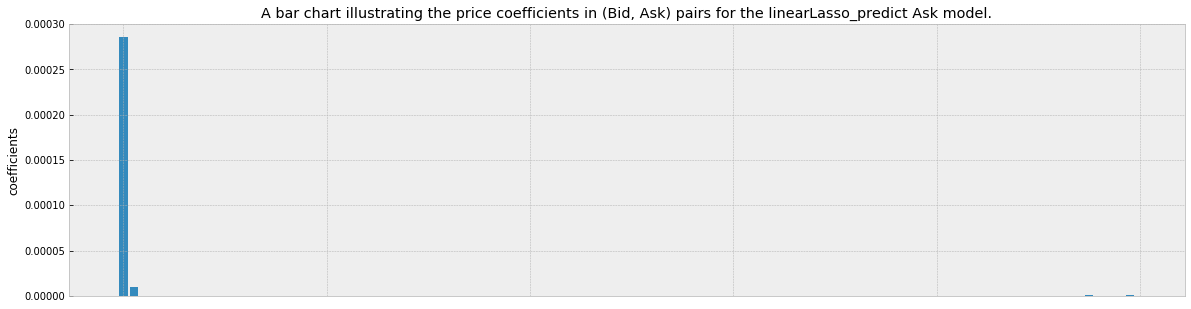

In [21]:
PlotBALinearCoefficients( "linearLasso_predict" )

In [ ]:
RMSE("linearLasso_predict.csv")

The unregularised model allocated small but non-zero coefficients to the transaction type features. As expected, the L1 regularisation has deselected these altogether. However it may have penalised too much, reducing the price coefficients to very small values. In addition, these coefficients no longer satisfy the intuition that events nearest the shock should contain the most predictive power. In fact, here the complete opposite appears to be true. It produced an RMSE of 1.08390, worse than the unregularised model.

It seems that $\lambda=0.0001$ is too large. This hyperparameter can be best selected by trialling values in a simple grid-search and selecting the $\lambda$ with the lowest RMSE. However, the test data cannot be used to select $\lambda$ as the model will simply be overfit on this set of data, giving an unrealistic performance. Instead the training data should be split up and $k$-fold cross-validation should be used. Then the RMSE for any given value of $\lambda$ is the average of the $k$ tests performed. This process takes some time and so we will explore other models before fine-tuning any particular one.

### Random Forest Regression

#### Regression Trees

Regression Trees are a natural extension to Classification Trees. Training features, $\boldsymbol{f}$, can be continuous or categorical and are used as inputs, $\boldsymbol{x}$, into the model to predict a continuous output, $y$.

A binary tree is constructed whereby at each node a binary question is asked of one of the features, e.g. $f_i<0.3?$ or $f_i = T?$ This partitions the $|\boldsymbol{f}|$-dimensional space into non-overlapping hypercubes, whereby any input belongs solely to one region: akin to a clustering algorithm. The prediction for a given input is first determined by following the tree to identify the region that $\boldsymbol{x}$ belongs to. This region contains a set of possible outputs from the original training data. The most basic prediction simply returns the mean of these outputs. A slightly more advanced technique is to build a multivariate linear regression model from this subset of training data, and return the predicted value by inputting $\boldsymbol{x}$.

In Classification Trees a greedy branching algorithm is used during training at each node to determine which feature should be questioned and at exactly what value. The information gain of each feature interogated at every possible value is calculated, usually using entropy as a metric, and the highest is selected for that node. Regression Trees are built in a very similar way, but now at each possible split the summed-square errors between the model (mean or linear model) and $y$-outputs is calculated for each cluster (left and right) and summed. Whichever split minimises this error is selected. This greedy algorithm locally attempts to minimise the global error of the tree (the sum of the errors in each end leaf).

This process could possibly continue until each training point was alone in its own leaf node. This would obviously overfit the training data and so there are several stopping criteria. One is to stop branching when the summed error of a possible split is less than some pre-specified threshold. More blunt methods simply insist on a maximum tree depth or minimum number of points in each cluster.

Regression Trees are very versatile. They naturally handle categorical data, are distribution-free and interpretable. They can model highly non-linear functions by making many local linear approximations.

#### Bagging

Deep Regression Trees typically have low bias but overfit the training data (high variance). Bagging (Bootstrap-Aggregating) is an ensemble method that averages the predictions of several deep trees to decrease this variance without increasing the bias. Each of these deep trees is trained on different data of the same sample size. Several hundred trees can be trained by bootstrapping the original training data: random sampling with replacement.

#### Random Forest Regression

Random Forest is another ensemble method used to reduce model variance even further. Each of its constituent trees are trained on different data (via bagging) but, in addition, the feature set is also randomly sampled at each node. That is, at each bifurcation within each tree, a random subset of features is selected over which to search for an optimal split. This improves the robustness of the model even more.

In [14]:
def RandomForestPredict():

    print("Setting up...")
    
    trainDataPath = dataPath_ + "encoded_train_data" + csvExt_
    predictTemplatePath = predictPath_ + "encoded_prediction_data" + csvExt_
    modelPath = modelsPath_ + "randomForest_predict" + modelExt_
    modelPredictPath = predictPath_ + "randomForest_predict" + csvExt_
    
    loadS3ToLocal(trainDataPath)
    train_data = pd.read_csv(trainDataPath)
    
    loadS3ToLocal(predictTemplatePath)
    prediction_data = pd.read_csv(predictTemplatePath)
    
    [featureColumns, predictionColumns, trainX, trainY_bid, trainY_ask] = setupBATrainingData(train_data)

    print("Fitting models...")
    
    RF_model_bid = ensemble.RandomForestRegressor(n_estimators=200,
                                                    criterion='mse',
                                                    max_depth=None)
    RF_model_bid.fit(trainX, trainY_bid)
    
    RF_model_ask = ensemble.RandomForestRegressor(n_estimators=200,
                                                    criterion='mse',
                                                    max_depth=None)
    RF_model_ask.fit(trainX, trainY_ask)
        
    print("Saving models...")
    model = [RF_model_bid, RF_model_ask]
    pickle.dump(model, open(modelPath, 'wb'))
    writeLocalToS3(modelPath)
    
    print("Predicting...")
    
    #fill in predict input (X)
    predictX = np.zeros((prediction_data.shape[0], len(featureColumns) ))
    for ix, row in prediction_data.iterrows():
        X = (np.array(row[featureColumns])).flatten('F')
        predictX[ix, :] = X

    predictY_bid = RF_model_bid.predict(predictX)
    predictY_ask = RF_model_ask.predict(predictX)
    
    for ix, row in prediction_data.iterrows():
        bid = predictY_bid[ix]
        ask = predictY_ask[ix]

        for column in predictionColumns:
            if column.startswith('bid'):
                prediction_data.set_value(ix, column, bid)
            else:
                prediction_data.set_value(ix, column, ask)
                
    print("Saving predictions...")
    prediction_data.to_csv(modelPredictPath, index=False)
    writeLocalToS3(modelPredictPath)
    
    display(prediction_data.head())

In [ ]:
RMSE("randomForest_predict.csv")

This Random Forest algorithm takes about an hour to train and produces an RMSE of 1.08533 - worse than regularised linear regression but better than the benchmark model.

Regression Trees can be used to analyse the importance of features. For a given feature, one can visit the nodes in the tree that condition on it and determine the error reduction that was achieved by branching. This can be computed as the reduction in a node's summed-square errors after spliting. This importance value can be averaged over all the trees in an ensemble to produce a ranking.

In [6]:
def PlotBAForestFeatureImportance():

    model_name = "randomForest_predict"
    modelPath = modelsPath_ + model_name + modelExt_
    predictTemplatePath = predictPath_ + "encoded_prediction_data" + csvExt_
    
    loadS3ToLocal(modelPath)
    [bidModel, askModel] = pickle.load(open(modelPath, 'rb'))
    models = {model_name + " Bid": bidModel, model_name + " Ask": askModel}

    loadS3ToLocal(predictTemplatePath)
    prediction_data = pd.read_csv(predictTemplatePath)

    predictionColumns = []
    for i in range(52, 101):
        for column in prediction_data.columns.values:
            if column.endswith(str(i)) and (column.startswith("bid") or column.startswith("ask")):
                predictionColumns.append(column)

    featureColumns = []
    for column in prediction_data.columns.values:
        if ((column not in predictionColumns) and (column != 'row_id') and (column != 'security_id') and (not column.startswith('time'))):
            featureColumns.append(column)

    #plot the liquidity trade properties coefficients
    for name, model in models.items():
        coeffs = model.feature_importances_
        propertyCoeffs = list(coeffs[0:5])
        propertyLabels = featureColumns[0:5]        

        fig, axis = plt.subplots(1, 1, figsize=(8, 5))
        axis.bar(propertyLabels, propertyCoeffs)
        axis.set_ylabel("coefficients")
        plt.title("A bar chart illustrating feature coefficients for the " + name + " model.")
        plt.show()

    # plot transtype coefficients    
    for name, model in models.items():  
        coeffs = model.feature_importances_
        transCoeffs = [coeffs[i] for i in range(len(featureColumns)) if featureColumns[i].startswith("trans")]

        fig, axis = plt.subplots(1, 1, figsize=(20, 5))
        axis.bar(range(1,51), transCoeffs)
        axis.set_ylabel("coefficients")
        plt.title("A bar chart illustrating the transaction type (is_Quote) coefficients for the " + name + " model." )
        plt.show()

    #plot price coefficients
    for name, model in models.items():  
        coeffs = model.feature_importances_
        priceCoeffs = [coeffs[i] for i in range(len(featureColumns)) if (featureColumns[i].startswith("bid") or featureColumns[i].startswith("ask"))]

        fig, axis = plt.subplots(1, 1, figsize=(20, 5))
        axis.bar(range(100), priceCoeffs)
        axis.tick_params(bottom=False, labelbottom=False) 
        axis.set_ylabel("coefficients")
        plt.title("A bar chart illustrating the price coefficients in (Bid, Ask) pairs for the " + name + " model." )
        plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


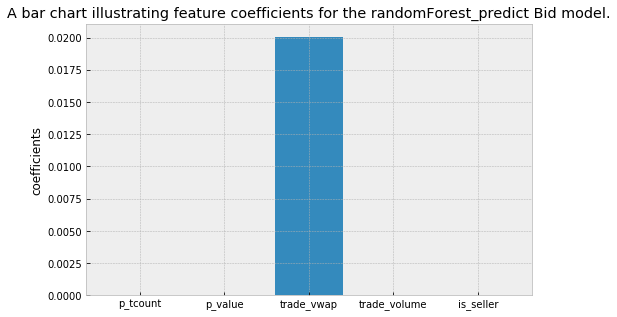

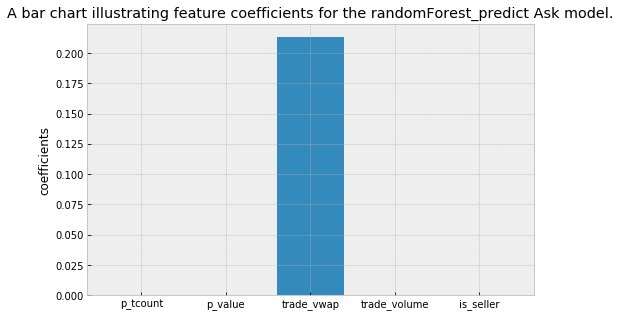

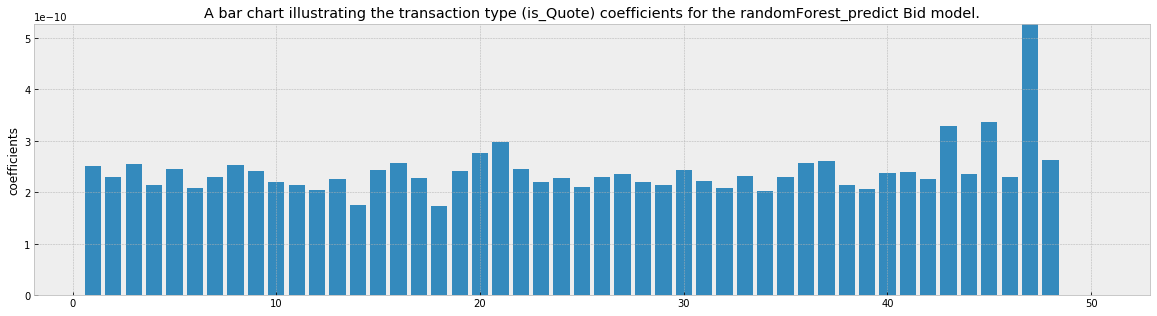

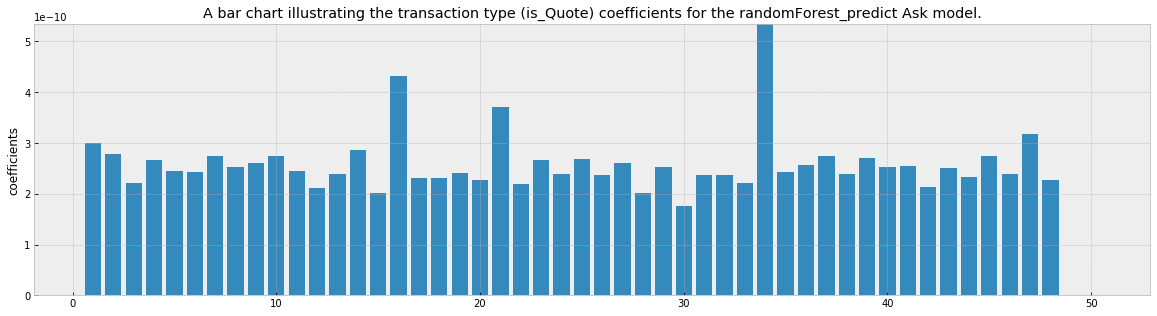

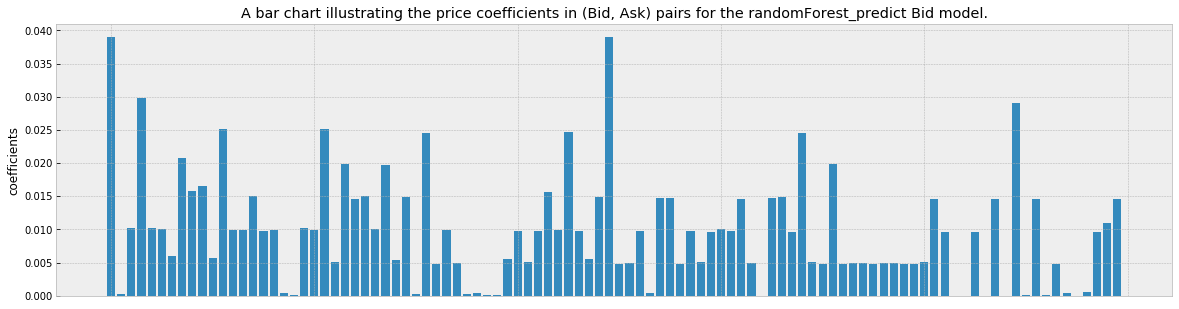

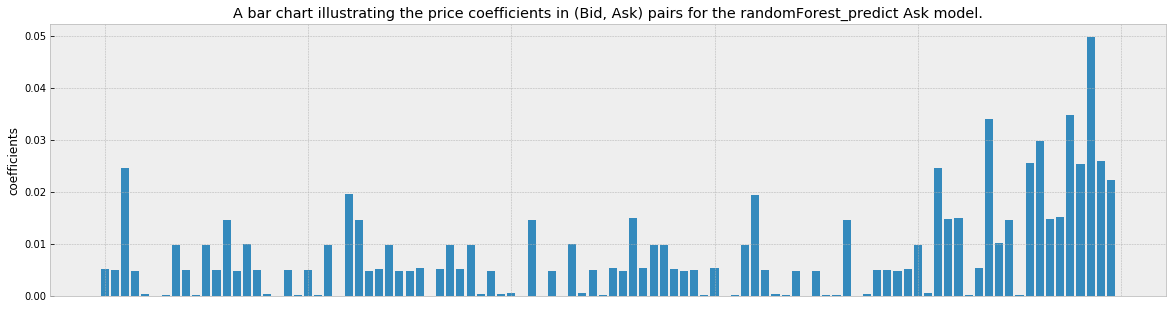

In [7]:
PlotBAForestFeatureImportance()

Of the initial features, just as in the linear regression models, trade_vwap is considered most important. Once the scale on the transaction type plots are noted, it is clear that these features carry very little information. The Ask model approximately matches the patterns seen before, in that it weights prices nearest the shock more heavily. Interestingly, this intuition is not followed by the Bid model.

## Feature Selection

Upon first inspection, it seems that Multivariate Linear Regression and Random Forest are most promising. k-Nearest-Neighbours and Support Vector Machine can also be used for regression problems, but they can take a very long time to train with such high dimensional data. I will now spend some time engineering the available features before turning my attention back to specific models and their fine tuning.

To prevent overfitting, it is important to remove features that appear to have very little predictive power. This can also occur if some of the features are highly correlated. Our previous analysis hints that the transaction type properties contain very little information. This makes intuitive sense: knowing that an event is a Trade, without being told which side it traded on, contributes nothing to a prediction of future prices. These features will be removed for all forthcoming models.

### *security_id* feature

So far we have considered the different securities to be indistinguishable. It seems reasonable that each security might behave differently to a shock and so the security_id could contain some valuable information. The following function replaces the security_id column with three binary columns: is_security_18, is_security_73, is_security_102.

In [8]:
def encodeSecurityData():
    
    trainPath = [dataPath_,"train_data" + csvExt_]
    predictionPath = [predictPath_,"prediction_data" + csvExt_]

    paths = [trainPath, predictionPath]
    
    for path in paths:
        
        print("Loading: " + path[0] + path[1])
        
        loadS3ToLocal(path[0] + path[1])
        data = pd.read_csv(path[0] + path[1])
        
        print("Encoding...")
        index = data.columns.get_loc('initiator')
        data.insert(index+1, 'is_seller', 0)
        data['is_seller'] = data['initiator'].apply(lambda x: 1 if x == 'S' else 0)
        data = data.drop('initiator', 1)
        
        index = data.columns.get_loc('security_id')
        data.insert(index+1, 'is_security_18', 0)
        data['is_security_18'] = data['security_id'].apply(lambda x: 1 if x == 18 else 0)
        
        data.insert(index+1, 'is_security_73', 0)
        data['is_security_73'] = data['security_id'].apply(lambda x: 1 if x == 73 else 0)
        
        data.insert(index+1, 'is_security_102', 0)
        data['is_security_102'] = data['security_id'].apply(lambda x: 1 if x == 102 else 0)
        data = data.drop('security_id', 1)
        
        print("Encoding completed:")
        display(data.head())
        
        print("Saving data...\n")
        data.to_csv(path[0] + "sec_encoded_" + path[1], index=False)
        writeLocalToS3(path[0] + "sec_encoded_" + path[1])

In [9]:
encodeSecurityData()

Loading: data/train_data.csv
Encoding...
Encoding completed:


,row_id,is_security_102,is_security_73,is_security_18,p_tcount,p_value,trade_vwap,trade_volume,is_seller,transtype1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
0,557262,0,1,0,17916,16972338272,3065.50,32,1,T,...,3065.50,3067.50,3065.50,3066.5,3065.50,3066.50,3065.50,3066.50,3065.50,3067.00
1,616724,0,0,1,25053,23715372270,458.55,958,1,Q,...,458.35,458.45,458.35,458.5,458.35,458.45,458.35,458.50,458.35,458.45
2,312426,0,1,0,21293,20760468802,3172.50,7,1,T,...,3169.00,3171.00,3169.00,3171.5,3169.00,3171.50,3169.00,3171.50,3169.50,3171.50
3,728848,0,0,1,11290,8379895754,405.40,4195,0,Q,...,405.25,405.60,405.25,405.6,405.25,405.60,405.25,405.55,405.30,405.55
4,559656,0,1,0,17916,16972338272,3128.50,32,1,Q,...,3129.00,3130.50,3129.50,3130.5,3129.50,3130.50,3129.00,3130.50,3128.50,3130.50


Saving data...

Loading: predictions/prediction_data.csv
Encoding...
Encoding completed:


,row_id,is_security_102,is_security_73,is_security_18,p_tcount,p_value,trade_vwap,trade_volume,is_seller,transtype1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
0,439495,0,1,0,16239,13909320205,3061.00,709,1,Q,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,82233,0,1,0,11552,10986877436,3293.00,109,1,Q,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,677727,0,1,0,19304,14603738564,3314.00,168,0,Q,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,339465,1,0,0,17510,11402659276,953.70,703,0,T,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,620065,0,0,1,25053,23715372270,459.25,2009,1,Q,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Saving data...



#### Linear Regression

We will first attempt to exploit the security_id information by training a standard linear regression model. Note that the transaction type features are no longer included.

In [16]:
def setupBASecTrainingData(train_data):
    
    bidPredictionColumns = []
    for i in range(52, 101):
        for column in train_data.columns.values:
            if column.endswith(str(i)) and column.startswith('bid'):
                bidPredictionColumns.append(column)

    askPredictionColumns = []
    for i in range(52, 101):
        for column in train_data.columns.values:
            if column.endswith(str(i)) and column.startswith('ask'):
                askPredictionColumns.append(column)

    predictionColumns = bidPredictionColumns + askPredictionColumns
    
    featureColumns = []
    for column in train_data.columns.values:
        if ((column not in predictionColumns) and (column != 'row_id') and (not column.startswith('trans')) and (not column.startswith('time'))):
            featureColumns.append(column)
            
    #fill in training input (X) and output (Y) data for both Ask/Bid models
    trainX = np.zeros((train_data.shape[0], len(featureColumns) ))
    trainY_bid = np.zeros((train_data.shape[0]))
    trainY_ask = np.zeros((train_data.shape[0]))
    
    for ix, row in train_data.iterrows():
        X = (np.array(row[featureColumns])).flatten('F')
        
        #pick out bid52 & ask52
        Y_bid = row[bidPredictionColumns[0]]
        Y_ask = row[askPredictionColumns[0]]

        trainX[ix, :] = X
        trainY_bid[ix] = Y_bid
        trainY_ask[ix] = Y_ask
        
    return [featureColumns, predictionColumns, trainX, trainY_bid, trainY_ask]
    
def LinearRegSecPredict():

    print("Setting up...")
    
    trainDataPath = dataPath_ + "sec_encoded_train_data" + csvExt_
    predictTemplatePath = predictPath_ + "sec_encoded_prediction_data" + csvExt_
    modelPath = modelsPath_ + "linearRegSec_predict" + modelExt_
    modelPredictPath = predictPath_ + "linearRegSec_predict" + csvExt_
    
    loadS3ToLocal(trainDataPath)
    train_data = pd.read_csv(trainDataPath)
    
    loadS3ToLocal(predictTemplatePath)
    prediction_data = pd.read_csv(predictTemplatePath)
    
    [featureColumns, predictionColumns, trainX, trainY_bid, trainY_ask] = setupBASecTrainingData(train_data)

    print("Fitting models...")
    
    LR_model_bid = lm.LinearRegression(fit_intercept=True, normalize=False)
    LR_model_bid.fit(trainX, trainY_bid)
    
    LR_model_ask = lm.LinearRegression(fit_intercept=True, normalize=False)
    LR_model_ask.fit(trainX, trainY_ask)    
        
    print("Saving models...")
    model = [LR_model_bid, LR_model_ask]
    pickle.dump(model, open(modelPath, 'wb'))
    writeLocalToS3(modelPath)
    
    print("Predicting...")
    
    #fill in predict input (X)
    predictX = np.zeros((prediction_data.shape[0], len(featureColumns) ))
    for ix, row in prediction_data.iterrows():
        X = (np.array(row[featureColumns])).flatten('F')
        predictX[ix, :] = X

    predictY_bid = LR_model_bid.predict(predictX)
    predictY_ask = LR_model_ask.predict(predictX)
    
    for ix, row in prediction_data.iterrows():
        bid = predictY_bid[ix]
        ask = predictY_ask[ix]

        for column in predictionColumns:
            if column.startswith('bid'):
                prediction_data.set_value(ix, column, bid)
            else:
                prediction_data.set_value(ix, column, ask)
                
    print("Saving predictions...")
    prediction_data.to_csv(modelPredictPath, index=False)
    writeLocalToS3(modelPredictPath)
    
    display(prediction_data.head())

In [5]:
LinearRegSecPredict()

Setting up...
Fitting models...
Saving models...
Predicting...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:87: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:89: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Saving predictions...


,row_id,is_security_102,is_security_73,is_security_18,p_tcount,p_value,trade_vwap,trade_volume,is_seller,transtype1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
0,439495,0,1,0,16239,13909320205,3061.00,709,1,Q,...,3060.521921,3061.834742,3060.521921,3061.834742,3060.521921,3061.834742,3060.521921,3061.834742,3060.521921,3061.834742
1,82233,0,1,0,11552,10986877436,3293.00,109,1,Q,...,3292.043583,3293.406610,3292.043583,3293.406610,3292.043583,3293.406610,3292.043583,3293.406610,3292.043583,3293.406610
2,677727,0,1,0,19304,14603738564,3314.00,168,0,Q,...,3313.108690,3314.606745,3313.108690,3314.606745,3313.108690,3314.606745,3313.108690,3314.606745,3313.108690,3314.606745
3,339465,1,0,0,17510,11402659276,953.70,703,0,T,...,953.292662,953.782465,953.292662,953.782465,953.292662,953.782465,953.292662,953.782465,953.292662,953.782465
4,620065,0,0,1,25053,23715372270,459.25,2009,1,Q,...,459.124243,459.265165,459.124243,459.265165,459.124243,459.265165,459.124243,459.265165,459.124243,459.265165


In [18]:
def PlotBASecLinearCoefficients():

    model_name = "linearRegSec_predict"
    modelPath = modelsPath_ + model_name + modelExt_
    predictTemplatePath = predictPath_ + "sec_encoded_prediction_data" + csvExt_
    
    loadS3ToLocal(modelPath)
    [bidModel, askModel] = pickle.load(open(modelPath, 'rb'))
    models = {model_name + " Bid": bidModel, model_name + " Ask": askModel}

    loadS3ToLocal(predictTemplatePath)
    prediction_data = pd.read_csv(predictTemplatePath)

    predictionColumns = []
    for i in range(52, 101):
        for column in prediction_data.columns.values:
            if column.endswith(str(i)) and (column.startswith("bid") or column.startswith("ask")):
                predictionColumns.append(column)

    featureColumns = []
    for column in prediction_data.columns.values:
        if ((column not in predictionColumns) and (column != 'row_id') and (not column.startswith('trans')) and (not column.startswith('time'))):
            featureColumns.append(column)

    #plot the liquidity trade properties coefficients
    for name, model in models.items():
        coeffs = model.coef_
        propertyCoeffs = list(coeffs[0:8])
        propertyLabels = featureColumns[0:8]        

        fig, axis = plt.subplots(1, 1, figsize=(12, 5))
        axis.bar(propertyLabels, propertyCoeffs)
        axis.set_ylabel("coefficients")
        plt.title("A bar chart illustrating feature coefficients for the " + name + " model.")
        plt.show()

    #plot price coefficients
    for name, model in models.items():
        coeffs = model.coef_
        priceCoeffs = [coeffs[i] for i in range(len(featureColumns)) if (featureColumns[i].startswith("bid") or featureColumns[i].startswith("ask"))]

        fig, axis = plt.subplots(1, 1, figsize=(20, 5))
        axis.bar(range(100), priceCoeffs)
        axis.tick_params(bottom=False, labelbottom=False) 
        axis.set_ylabel("coefficients")
        plt.title("A bar chart illustrating the price coefficients in (Bid, Ask) pairs for the " + name + " model." )
        plt.show()

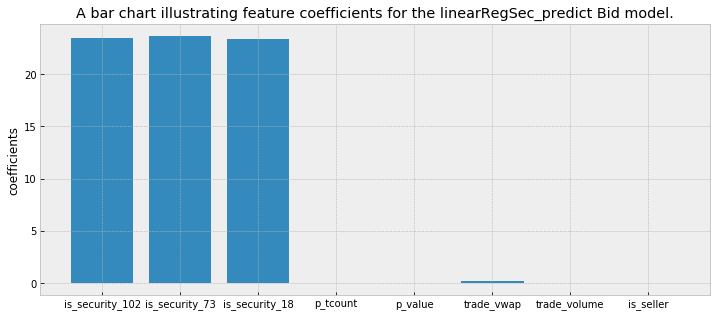

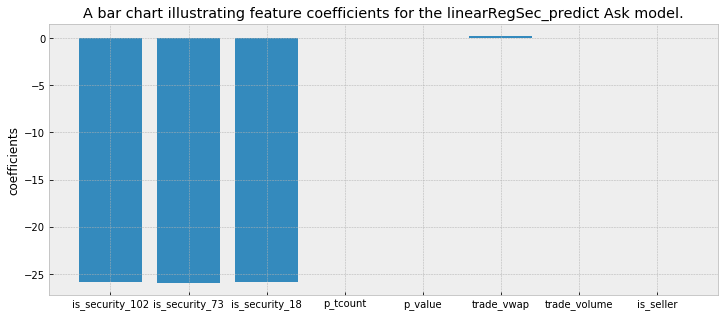

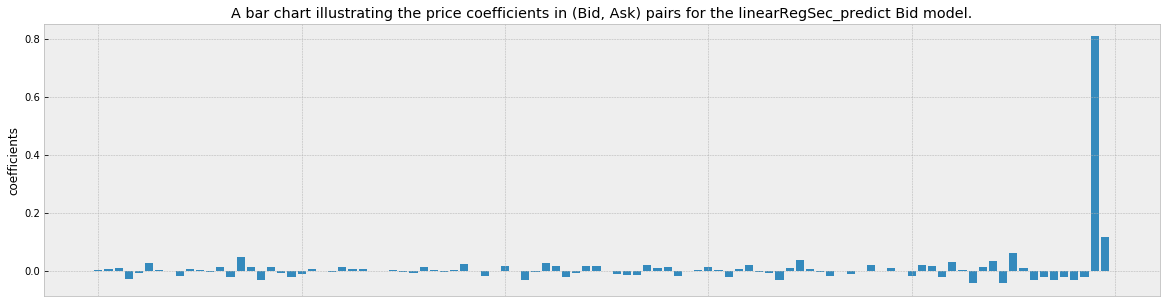

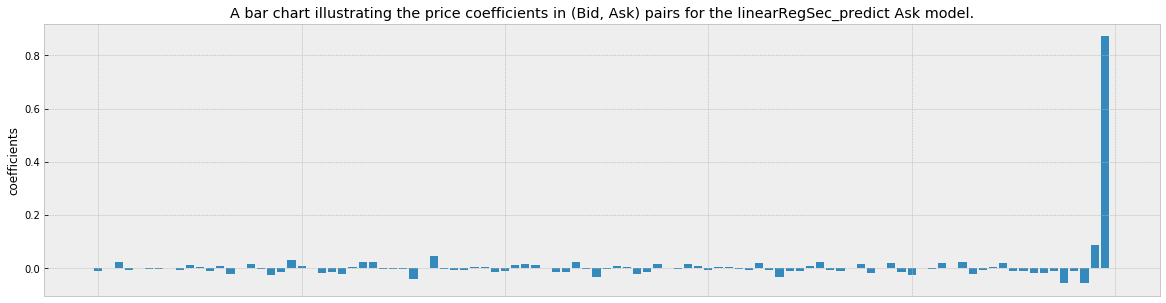

In [19]:
PlotBASecLinearCoefficients()

Initially, as with all previous linear regression models, I normalised the data to aid analysis of the coefficients. However, this had the opposite effect and produced coefficients of vastly different scale. Oddly the coefficients become more interpretable when the data is left unnormalised.

Upon first glance it seems that both models consider the new security_id features to possess a large amount of predictive power. However, recall that these values are at most 1 whilst trade_vwap is several orders of magnitude larger since it is measured in pence. Hence it is not clear which features the models consider to be most important. The price information is weighted in a similar intuitive way as before.

In [ ]:
RMSE("linearRegSec_predict.csv")

The security_id features appear to have improved our model very slightly, achieving an RMSE of 1.06403.

#### Random Forest Regression

We will now build a Random Forest model that attempts to exploit differences between the securities.

In [21]:
def RandomForestSecPredict():

    print("Setting up...")
    
    trainDataPath = dataPath_ + "sec_encoded_train_data" + csvExt_
    predictTemplatePath = predictPath_ + "sec_encoded_prediction_data" + csvExt_
    modelPath = modelsPath_ + "randomForestSec_predict" + modelExt_
    modelPredictPath = predictPath_ + "randomForestSec_predict" + csvExt_
    
    loadS3ToLocal(trainDataPath)
    train_data = pd.read_csv(trainDataPath)
    
    loadS3ToLocal(predictTemplatePath)
    prediction_data = pd.read_csv(predictTemplatePath)
    
    [featureColumns, predictionColumns, trainX, trainY_bid, trainY_ask] = setupBASecTrainingData(train_data)

    print("Fitting models...")
    
    RF_model_bid = ensemble.RandomForestRegressor(n_estimators=200,
                                                    criterion='mse',
                                                    max_depth=None)
    RF_model_bid.fit(trainX, trainY_bid)
    
    RF_model_ask = ensemble.RandomForestRegressor(n_estimators=200,
                                                    criterion='mse',
                                                    max_depth=None)
    RF_model_ask.fit(trainX, trainY_ask)
        
    print("Saving models...")
    model = [RF_model_bid, RF_model_ask]
    pickle.dump(model, open(modelPath, 'wb'))
    writeLocalToS3(modelPath)
    
    print("Predicting...")
    
    #fill in predict input (X)
    predictX = np.zeros((prediction_data.shape[0], len(featureColumns) ))
    for ix, row in prediction_data.iterrows():
        X = (np.array(row[featureColumns])).flatten('F')
        predictX[ix, :] = X

    predictY_bid = RF_model_bid.predict(predictX)
    predictY_ask = RF_model_ask.predict(predictX)
    
    for ix, row in prediction_data.iterrows():
        bid = predictY_bid[ix]
        ask = predictY_ask[ix]

        for column in predictionColumns:
            if column.startswith('bid'):
                prediction_data.set_value(ix, column, bid)
            else:
                prediction_data.set_value(ix, column, ask)
                
    print("Saving predictions...")
    prediction_data.to_csv(modelPredictPath, index=False)
    writeLocalToS3(modelPredictPath)
    
    display(prediction_data.head())

In [ ]:
RandomForestSecPredict()

In [ ]:
RMSE("randomForestSec_predict.csv")

Again, the security_id features appear to contain a very small amount of predictive power, reducing the RMSE slightly to 1.08426.

In [4]:
def PlotBASecForestFeatureImportance():

    model_name = "randomForestSec_predict"
    modelPath = modelsPath_ + model_name + modelExt_
    predictTemplatePath = predictPath_ + "sec_encoded_prediction_data" + csvExt_
    
    loadS3ToLocal(modelPath)
    [bidModel, askModel] = pickle.load(open(modelPath, 'rb'))
    models = {model_name + " Bid": bidModel, model_name + " Ask": askModel}

    loadS3ToLocal(predictTemplatePath)
    prediction_data = pd.read_csv(predictTemplatePath)

    predictionColumns = []
    for i in range(52, 101):
        for column in prediction_data.columns.values:
            if column.endswith(str(i)) and (column.startswith("bid") or column.startswith("ask")):
                predictionColumns.append(column)

    featureColumns = []
    for column in prediction_data.columns.values:
        if ((column not in predictionColumns) and (column != 'row_id') and (not column.startswith('trans')) and (not column.startswith('time'))):
            featureColumns.append(column)

    #plot the liquidity trade properties coefficients
    for name, model in models.items():
        coeffs = model.feature_importances_
        propertyCoeffs = list(coeffs[0:8])
        propertyLabels = featureColumns[0:8]        

        fig, axis = plt.subplots(1, 1, figsize=(12, 5))
        axis.bar(propertyLabels, propertyCoeffs)
        axis.set_ylabel("coefficients")
        plt.title("A bar chart illustrating feature coefficients for the " + name + " model.")
        plt.show()

    #plot price coefficients
    for name, model in models.items():  
        coeffs = model.feature_importances_
        priceCoeffs = [coeffs[i] for i in range(len(featureColumns)) if (featureColumns[i].startswith("bid") or featureColumns[i].startswith("ask"))]

        fig, axis = plt.subplots(1, 1, figsize=(20, 5))
        axis.bar(range(100), priceCoeffs)
        axis.tick_params(bottom=False, labelbottom=False) 
        axis.set_ylabel("coefficients")
        plt.title("A bar chart illustrating the price coefficients in (Bid, Ask) pairs for the " + name + " model." )
        plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


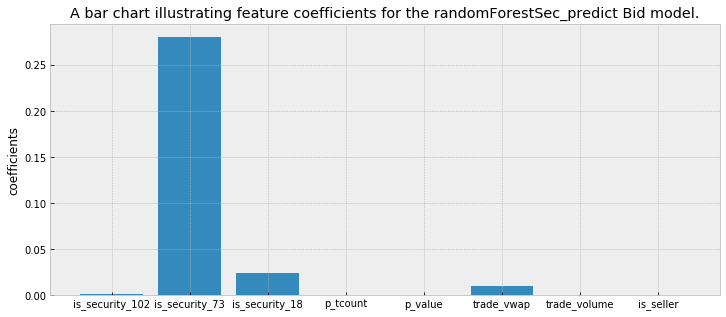

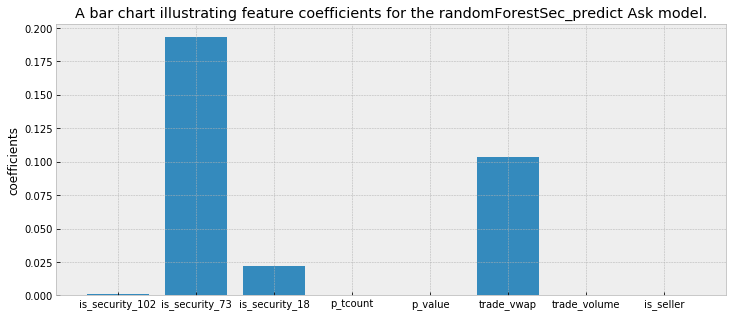

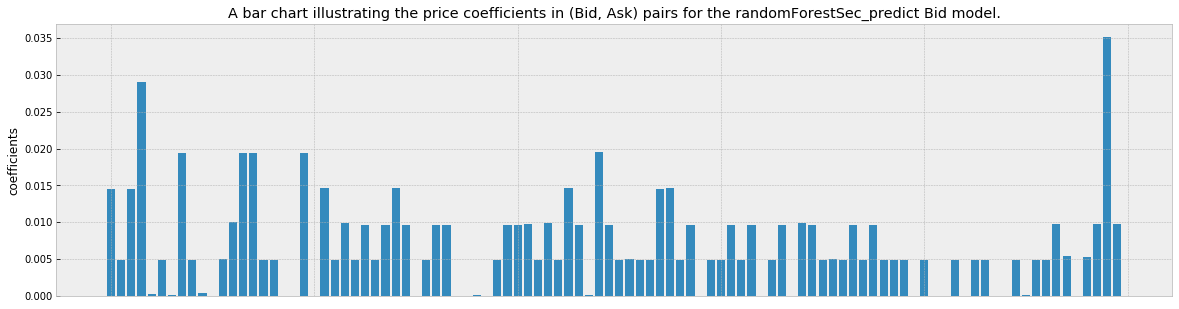

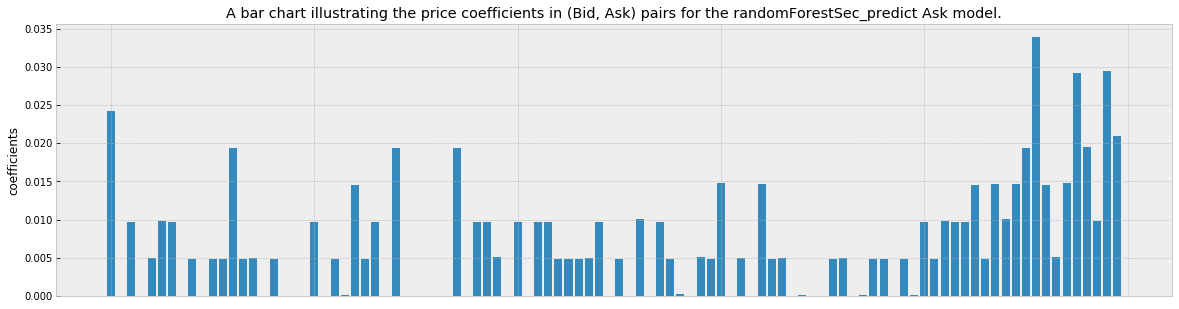

In [5]:
PlotBASecForestFeatureImportance()

It is interesting to note that both models consider the is_security_73 feature to possess more predictive power than the other security labels. Recall that security 73 has a much higher price than the other two included in the sample, perhaps causing it to react differently to a shock. In addition, the Ask model now weights trade_vwap much more highly than the Bid model.

### a model for each security...

Both the Linear Regression and Random Forest algorithms seem to be able to exploit the security categories somewhat. A natural extension is to suggest that each security might behave so differently to a shock that they warant their own individual model. Each security will have its own dedicated model, which in turn is constructed of a Bid and Ask model, that is trained solely on that security's data. Whilst it is true that each model will be trained on less data, it is also given the opportunity to specialise on the dynamics of just one security.

In [13]:
def setupBAIndivSecTrainingData(train_data):
    
    securityToTrainX = {18: None, 73: None, 102: None}
    securityToTrainY = {18: {}, 73: {}, 102: {}}
    
    bidPredictionColumns = []
    for i in range(52, 101):
        for column in train_data.columns.values:
            if column.endswith(str(i)) and column.startswith('bid'):
                bidPredictionColumns.append(column)

    askPredictionColumns = []
    for i in range(52, 101):
        for column in train_data.columns.values:
            if column.endswith(str(i)) and column.startswith('ask'):
                askPredictionColumns.append(column)

    predictionColumns = bidPredictionColumns + askPredictionColumns
    
    featureColumns = []
    for column in train_data.columns.values:
        if ((column not in predictionColumns) and (column != 'row_id') and (column != 'security_id') and (not column.startswith('trans')) and (not column.startswith('time'))):
            featureColumns.append(column)
            
    #for each security        
    for security in securityToTrainX.keys():
        indivTrainData = train_data.loc[ train_data['security_id']==security, :]

        #fill in training input (X) and output (Y) data for both Ask/Bid models
        trainX = np.zeros((indivTrainData.shape[0], len(featureColumns) ))
        trainY_bid = np.zeros((indivTrainData.shape[0]))
        trainY_ask = np.zeros((indivTrainData.shape[0]))

        index = 0
        for ix, row in indivTrainData.iterrows():
            X = (np.array(row[featureColumns])).flatten('F')

            #pick out bid52 & ask52
            Y_bid = row[bidPredictionColumns[0]]
            Y_ask = row[askPredictionColumns[0]]

            trainX[index, :] = X
            trainY_bid[index] = Y_bid
            trainY_ask[index] = Y_ask
            index += 1

        securityToTrainX[ security ] = trainX
        securityToTrainY[ security ]['Bid'] = trainY_bid
        securityToTrainY[ security ]['Ask'] = trainY_ask
        
    return [featureColumns, predictionColumns, securityToTrainX, securityToTrainY]
    
def LinearRegIndivSecPredict():

    print("Setting up...")
    
    trainDataPath = dataPath_ + "encoded_train_data" + csvExt_
    predictTemplatePath = predictPath_ + "encoded_prediction_data" + csvExt_
    modelPath = modelsPath_ + "linearRegIndivSec_predict" + modelExt_
    modelPredictPath = predictPath_ + "linearRegIndivSec_predict" + csvExt_
    
    securityToModel = {18: {}, 73: {}, 102: {}}
    
    loadS3ToLocal(trainDataPath)
    train_data = pd.read_csv(trainDataPath)
    
    loadS3ToLocal(predictTemplatePath)
    prediction_data = pd.read_csv(predictTemplatePath)
    
    [featureColumns, predictionColumns, securityToTrainX, securityToTrainY] = setupBAIndivSecTrainingData(train_data)

    print("Fitting models...")
    
    for security in securityToModel.keys():
        LR_model_bid = lm.LinearRegression(fit_intercept=True, normalize=True)
        LR_model_bid.fit(securityToTrainX[security], securityToTrainY[security]['Bid'])
        securityToModel[security]['Bid'] = LR_model_bid
        
        LR_model_ask = lm.LinearRegression(fit_intercept=True, normalize=True)
        LR_model_ask.fit(securityToTrainX[security], securityToTrainY[security]['Ask'])  
        securityToModel[security]['Ask'] = LR_model_ask
        
    print("Saving models...")
    pickle.dump(securityToModel, open(modelPath, 'wb'))
    writeLocalToS3(modelPath)
    
    print("Predicting...")
    
    for ix, row in prediction_data.iterrows():
        security_id = row['security_id']
        X = (np.array(row[featureColumns])).flatten('F').reshape(1, -1)
        
        predictY_bid = securityToModel[security_id]['Bid'].predict(X)
        predictY_ask = securityToModel[security_id]['Ask'].predict(X)
        
        for column in predictionColumns:
            if column.startswith('bid'):
                prediction_data.set_value(ix, column, predictY_bid)
            else:
                prediction_data.set_value(ix, column, predictY_ask)
        
    
    print("Saving predictions...")
    prediction_data.to_csv(modelPredictPath, index=False)
    writeLocalToS3(modelPredictPath)
    
    display(prediction_data.head())

In [5]:
LinearRegIndivSecPredict()

Setting up...
Fitting models...
Saving models...
Predicting...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:98: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:100: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Saving predictions...


,row_id,security_id,p_tcount,p_value,trade_vwap,trade_volume,is_seller,transtype1_is_Q,time1,bid1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
0,439495,73,16239,13909320205,3061.00,709,1,1,14:01:44.197,3057.0,...,3060.511825,3061.821408,3060.511825,3061.821408,3060.511825,3061.821408,3060.511825,3061.821408,3060.511825,3061.821408
1,82233,73,11552,10986877436,3293.00,109,1,1,15:16:30.978,3294.0,...,3291.999082,3293.417623,3291.999082,3293.417623,3291.999082,3293.417623,3291.999082,3293.417623,3291.999082,3293.417623
2,677727,73,19304,14603738564,3314.00,168,0,1,14:42:39.385,3313.5,...,3313.116245,3314.622482,3313.116245,3314.622482,3313.116245,3314.622482,3313.116245,3314.622482,3313.116245,3314.622482
3,339465,102,17510,11402659276,953.70,703,0,0,08:33:26.433,953.5,...,953.284892,953.761046,953.284892,953.761046,953.284892,953.761046,953.284892,953.761046,953.284892,953.761046
4,620065,18,25053,23715372270,459.25,2009,1,1,16:12:27.546,459.3,...,459.096374,459.289040,459.096374,459.289040,459.096374,459.289040,459.096374,459.289040,459.096374,459.289040


In [ ]:
RMSE("linearRegIndivSec_predict.csv")

By dedicating a single model to each security we have managed to squeeze out a little more predictive power, achieving an RMSE of 1.06383. However, given the additional complexity that this has introduced into the training of the models, it is perhaps not worth pursuing further.

In addition, this method doesn't scale very well to a marketplace potentially containing many thousands of different securities. I would probably even struggle to handle the full 102 different securities that were present in the original Kaggle data.

### non-constant model

Thus far all of our models have simply attempted to predict bid52/ask52, assuming constant prices thereafter. Plots depicting mean error as a function of event confirm our intuition: these models perform worse the further we get from the liquidity shock.

The simplest extension is to partition these future events into regions of constant price. For example, the partitions could be:

1. \[52, 53, 54, 55, 56, 57, 58, 59, 60\]
2. \[61, 62, 63, 64, 65, 66, 67, 68, 69, 70\]
3. \[71, 72, 73, 74, 75, 76, 77, 78, 79, 80\]
4. \[81, 82, 83, 84, 85, 86, 87, 88, 89, 90\]
5. \[91, 92, 93, 94, 95, 96, 97, 98, 99, 100\]

Each partition is served by a different model, which in turn is composed of two Bid/Ask models. In this way we can bootstrap our predictions such that the model for partition $i$ takes in all of the usual pre-shock features as inputs but also utilises the predictions made in partition $i-1$.

For the example above, the model for partition 1 is very similar to our previous approaches: it is trained on the usual pre-shock features and attempts to predict bid52/ask52, assuming a constant price up until bid60/ask60. However, the model for partition 2 is additionally trained on events 52-60. During prediction it requires the usual pre-shock inputs but also attempts to exploit the constant prediction made by model 1 for events 52-60. Using all of this information model 2 attempts to predict bid61/ask61, assuming a constant price until bid70/ask70.


In [2]:
def setupBASlotTrainingData(train_data, slots):
    
    bidPredictionColumns = []
    askPredictionColumns = []
    for i in range(52, 101):
        for column in train_data.columns.values:
            if column.endswith(str(i)) and column.startswith('bid'):
                bidPredictionColumns.append(column)
            if column.endswith(str(i)) and column.startswith('ask'):
                askPredictionColumns.append(column)

    basePredictionColumns = bidPredictionColumns + askPredictionColumns

    baseFeatureColumns = []
    for column in train_data.columns.values:
        if ((column not in basePredictionColumns) and (column != 'row_id') and (not column.startswith('trans')) and (not column.startswith('time'))):
            baseFeatureColumns.append(column)

    slotToFeatureColumns = [0]*len(slots)
    slotToFeatureColumns[0] = baseFeatureColumns

    #miss out first slot - already in slotToFeatureColumns
    for i in range(1, len(slots)):
        #copy the features for the previous slot
        featurecolumns = slotToFeatureColumns[i-1].copy()

        #add in the timestamps from the previous slot
        for timestamp in slots[i-1]:
            featurecolumns.append('bid' + str(timestamp))
            featurecolumns.append('ask' + str(timestamp))
            
        slotToFeatureColumns[i] = featurecolumns

    slotToTrainX = []
    slotToTrainY_bid = []
    slotToTrainY_ask = []

    #for each timeslot
    for i in range(len(slots)):

        #fill in training input (X) and output (Y) data for both Ask/Bid models
        trainX = np.zeros(( train_data.shape[0], len(slotToFeatureColumns[i]) ))
        trainY_bid = np.zeros((train_data.shape[0]))
        trainY_ask = np.zeros((train_data.shape[0]))

        index = 0
        for ix, row in train_data.iterrows():
            X = (np.array(row[slotToFeatureColumns[i]])).flatten('F')

            #pick out first bidN & askN in each timeslot
            Y_bid = row['bid' + str(slots[i][0])]
            Y_ask = row['ask' + str(slots[i][0])]

            trainX[index, :] = X
            trainY_bid[index] = Y_bid
            trainY_ask[index] = Y_ask
            index += 1

        slotToTrainX.append(trainX)
        slotToTrainY_bid.append(trainY_bid)
        slotToTrainY_ask.append(trainY_ask)
        
        print("Setup timeslot: {}".format(slots[i]))

    return [slotToFeatureColumns, slotToTrainX, slotToTrainY_bid, slotToTrainY_ask]
    
def LinearRegSlotPredict(slots, modelName):

    #slots must be in numerical order!
    
    print("Setting up...")
    
    trainDataPath = dataPath_ + "sec_encoded_train_data" + csvExt_
    predictTemplatePath = predictPath_ + "sec_encoded_prediction_data" + csvExt_
    modelPath = modelsPath_ + modelName + modelExt_
    modelPredictPath = predictPath_ + modelName + csvExt_
    
    loadS3ToLocal(trainDataPath)
    train_data = pd.read_csv(trainDataPath)
    
    loadS3ToLocal(predictTemplatePath)
    prediction_data = pd.read_csv(predictTemplatePath)
    
    [slotToFeatureColumns, slotToTrainX, slotToTrainY_bid, slotToTrainY_ask] = setupBASlotTrainingData(train_data, slots)

    print("Fitting models...")
    
    slotToBidAsk = []
    for i in range(len(slots)):
        bidAskToModel = {}
        
        LR_model_bid = lm.LinearRegression(fit_intercept=True, normalize=True)
        LR_model_bid.fit(slotToTrainX[i], slotToTrainY_bid[i])
        bidAskToModel['Bid'] = LR_model_bid
        
        LR_model_ask = lm.LinearRegression(fit_intercept=True, normalize=True)
        LR_model_ask.fit(slotToTrainX[i], slotToTrainY_ask[i])
        bidAskToModel['Ask'] = LR_model_ask
        
        slotToBidAsk.append(bidAskToModel)
        
    slotsAndModels = [slots, slotToBidAsk]
        
    print("Saving models...")
    pickle.dump(slotsAndModels, open(modelPath, 'wb'))
    writeLocalToS3(modelPath)
    
    print("Predicting...")
    
    for i in range(len(slots)):

        #fill in predict input (X)
        predictX = np.zeros((prediction_data.shape[0], len(slotToFeatureColumns[i]) ))
        for ix, row in prediction_data.iterrows():
            X = (np.array(row[slotToFeatureColumns[i]])).flatten('F')
            predictX[ix, :] = X

        predictY_bid = slotToBidAsk[i]['Bid'].predict(predictX)
        predictY_ask = slotToBidAsk[i]['Ask'].predict(predictX)

        predictionColumns = []
        for timeslot in slots[i]:
            predictionColumns.append('bid' + str(timeslot))
            predictionColumns.append('ask' + str(timeslot))

        for ix, row in prediction_data.iterrows():
            bid = predictY_bid[ix]
            ask = predictY_ask[ix]

            for column in predictionColumns:
                if column.startswith('bid'):
                    prediction_data.set_value(ix, column, bid)
                else:
                    prediction_data.set_value(ix, column, ask)
                    
        print("Predicted timeslot: {}".format(slots[i]))
               
            
    print("Saving predictions...")
    prediction_data.to_csv(modelPredictPath, index=False)
    writeLocalToS3(modelPredictPath)
    
    display(prediction_data.head())

In [3]:
#these must be in numerical order
slot1 = [i for i in range(52, 61)]
slot2 = [i for i in range(61, 71)]
slot3 = [i for i in range(71, 81)]
slot4 = [i for i in range(81, 91)]
slot5 = [i for i in range(91, 101)]

slots = [slot1, slot2, slot3, slot4, slot5]

LinearRegSlotPredict(slots, "linearRegSlot_predict")

Setting up...
Setup timeslot: [52, 53, 54, 55, 56, 57, 58, 59, 60]
Setup timeslot: [61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
Setup timeslot: [71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
Setup timeslot: [81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
Setup timeslot: [91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
Fitting models...
Saving models...
Predicting...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:139: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:141: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Predicted timeslot: [52, 53, 54, 55, 56, 57, 58, 59, 60]
Predicted timeslot: [61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
Predicted timeslot: [71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
Predicted timeslot: [81, 82, 83, 84, 85, 86, 87, 88, 89, 90]
Predicted timeslot: [91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
Saving predictions...


,row_id,is_security_102,is_security_73,is_security_18,p_tcount,p_value,trade_vwap,trade_volume,is_seller,transtype1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
0,439495,0,1,0,16239,13909320205,3061.00,709,1,Q,...,3060.410938,3061.815262,3060.410938,3061.815262,3060.410938,3061.815262,3060.410938,3061.815262,3060.410938,3061.815262
1,82233,0,1,0,11552,10986877436,3293.00,109,1,Q,...,3292.042074,3293.438286,3292.042074,3293.438286,3292.042074,3293.438286,3292.042074,3293.438286,3292.042074,3293.438286
2,677727,0,1,0,19304,14603738564,3314.00,168,0,Q,...,3313.000278,3314.645844,3313.000278,3314.645844,3313.000278,3314.645844,3313.000278,3314.645844,3313.000278,3314.645844
3,339465,1,0,0,17510,11402659276,953.70,703,0,T,...,953.313823,953.755920,953.313823,953.755920,953.313823,953.755920,953.313823,953.755920,953.313823,953.755920
4,620065,0,0,1,25053,23715372270,459.25,2009,1,Q,...,459.137094,459.261871,459.137094,459.261871,459.137094,459.261871,459.137094,459.261871,459.137094,459.261871


The function LinearRegSlotPredict() builds this model for the arbitrary partition suggested above. It can take some time since it has to setup the data for and train $5\times 2$ Linear Regression models.

The plot below illustrates the piecewise modelling approach taken after the shock.

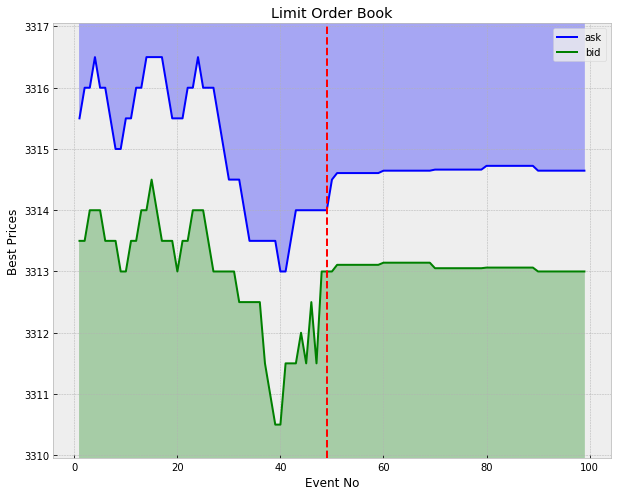

,row_id,is_security_102,is_security_73,is_security_18,p_tcount,p_value,trade_vwap,trade_volume,is_seller,transtype1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
2,677727,0,1,0,19304,14603738564,3314.0,168,0,Q,...,3313.000278,3314.645844,3313.000278,3314.645844,3313.000278,3314.645844,3313.000278,3314.645844,3313.000278,3314.645844


In [7]:
predictPath = predictPath_ + "linearRegSlot_predict" + csvExt_
PlotShock(predictPath, 677727)

In [ ]:
RMSE("linearRegSlot_predict.csv")

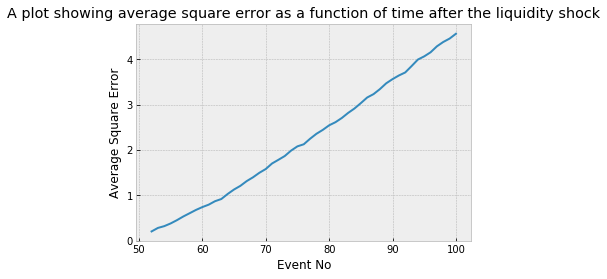

In [13]:
PlotErrorsAgainstEvent("errors_linearRegSlot_predict.csv")

This model achieves an improved RMSE of 1.05558. Perhaps unsurprisingly, the plot above shows that it still loses accuracy linearly as we move away from the shock event.

Nevertheless, our first partition was rather arbitrary. A [report](http://www.ms.k.u-tokyo.ac.jp/2013/Kaggle.pdf) written by the competition winner, suggests that we should employ tighter ranges just after the liquidity shock, since this is when prices move most rapidly and we might still expect to eek some predictive power out of the pre-shock data.

We will attempt to achieve more granular results after the shock by modelling the first 5 events individually (52-56), the next 5 events will be grouped (57-61), the next 10 events will be grouped (62-71) and the remaining events will be grouped (72-100).

In [ ]:
#these must be in numerical order
slot1 = [52]
slot2 = [53]
slot3 = [54]
slot4 = [55]
slot5 = [56]
slot6 = [57, 58, 59, 60, 61]
slot7 = [i for i in range(62, 72)]
slot8 = [i for i in range(72, 101)]

slots = [slot1, slot2, slot3, slot4, slot5, slot6, slot7, slot8]

LinearRegSlotPredict(slots, "linearRegFineSlot_predict")

Setting up...
Setup timeslot: [52]
Setup timeslot: [53]
Setup timeslot: [54]
Setup timeslot: [55]
Setup timeslot: [56]


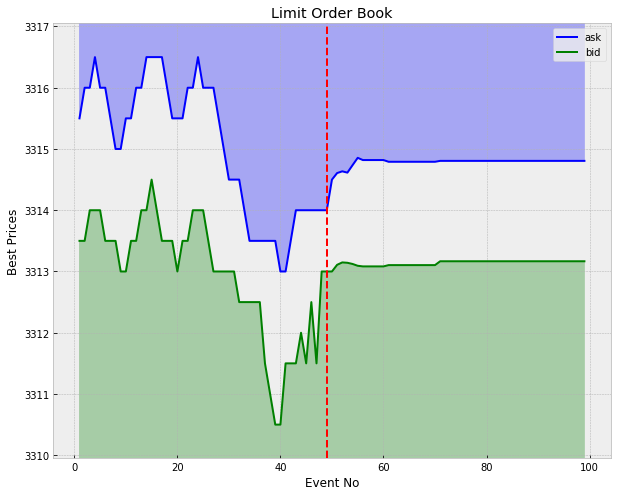

,row_id,is_security_102,is_security_73,is_security_18,p_tcount,p_value,trade_vwap,trade_volume,is_seller,transtype1,...,bid96,ask96,bid97,ask97,bid98,ask98,bid99,ask99,bid100,ask100
2,677727,0,1,0,19304,14603738564,3314.0,168,0,Q,...,3313.166901,3314.805949,3313.166901,3314.805949,3313.166901,3314.805949,3313.166901,3314.805949,3313.166901,3314.805949


In [6]:
predictPath = predictPath_ + "linearRegFineSlot_predict" + csvExt_
PlotShock(predictPath, 677727)

In [ ]:
RMSE("linearRegFineSlot_predict.csv")

The plot above illustrates the higher resolution predictions just after the shock and the larger regions of constant prices thereafter. This has again improved our RMSE to 1.03942.

## Results So Far ##

Below I describe each of the models built thus far alongside their RMSE score:

* **benchmark**: constant bid50/ask50 prices after shock. **1.09998**
* **linearReg**: two Multivariate Linear Regression models predicting bid52 and ask52, constant thereafter. Each model was trained on all bid/ask prices, encoded initiator and transaction type but not security_id. Trained on encoded_train_data. **1.06442**
* **linearLasso**: same as linearReg but each model was now regularised with Lasso penalty term. **1.08390**
* **randomForest**: two Random Forest Regression models predicting bid52 and ask52, constant thereafter. Trained on same features as linearReg. **1.08533**
* **linearRegSec**: transaction type features were now removed and encoded security_id was introduced. Trained on sec_encoded_train_data. **1.06403**
* **randomForestSec**: trained on same features as linearRegSec. **1.08426**
* **linearRegIndivSec**: different model for each security, each of which was still comprised of two bid/ask models. Transaction type was again ignored. Trained on encoded_train_data. **1.06383**
* **linearRegSlot**: partition future events into slots and predict constant prices within each slot. Bootstrap predictions by using partition $i-1$ as feature inputs into the model for partition $i$. Uniform partitions were selected in the first instance. Trained on sec_encoded_train_data. **1.05558**
* **linearRegFineSlot**: select finer resolution partitions just after the liquidity shock. **1.03942**

## Further Work ##

There is certainly lots more work to be done here. The winning Kaggle score was 0.7694. My data sets are slightly different since the original testing data was no longer available. In addition, I specialised to just three different securities meaning that really I should be able to beat this score. The following is a list of further work to be done on this project, approximately in order of importance:

* **Feature Engineering**: I have squeezed as much predictive power out of the information provided in the data set as it stands. I now need to begin engineering my own features. Here intuition must play an important role. Recall that there are three dimensions to liquidity: *spread*, *depth* and *resiliency*. Here we are attempting to predict the resiliency of the book, but clearly they all affect one another in complex ways. Existing research in this field [[1]](https://pdfs.semanticscholar.org/0e78/73f3f0ded2d177cb7b5e83b4ce4f9653ea35.pdf) also suggests that order arrival rate plays a large role. This leads to the following feature taxonomy:

    * **Price**: clearly current prices in some way reflect future prices (unless you believe in the Efficient Market Hypothesis). Thus far we have simply used the bid/ask prices prior to the shock, but also seen that only the last few are really exploited by the algorithms. I think many of these could be disposed of and replaced with statistics for the bid/ask time series: min/max/median/mean/standard deviation of the prices over the last $n$ events. These rolling statistics will allow for a longer term and shorter term view of each series.
    * **Spread**: this is the time series represented by the (bid$-$ask) at each event. A similar set of statistics could be computed as for the bid/ask prices.
    * **Depth**: unfortunately the volume available at each price level is not included in this data set. Nevertheless proxies for depth could be considered: the number of price improvements over the last $n$ events. For the bid (selling) this would be price increases and for the ask (buying) this would be price decreases. A larger number of price improvements on any one side suggests ample volume at the best bid/ask. Two variables included in the training data are already proxies for depth: *p_tcount* (the previous day's number of on-market trades in a given security) and *p_value* (the previous day's on-market notional traded in a given security).
    * **Rate**: the number of trades/quotes over the last $n$ events. These could hint at liquidity diminishing/growing respectively. 
    
  A lot of potential features could be generated, though certainly some of them will have no predictive power or be correlated to others. Analysis of feature coefficients/importance can be used to remove unuseful predictors. This can be achieved automatically by using Lasso regularisation. Multicollinearity can be tackled by analysing the pairwise feature correlations or using Principle Component Analysis in an attempt to reduce the dimensionality of the feature space. Ultimately intuition and a systematic approach will have to be employed: remove features one-at-a-time from the training set and determine the performance of the resulting model. It is also important that the test data is not used to perform large-scale feature selection like this as the model will simply be overfit. Cross-validation should be used instead.
  
* **Alternative Regression algorithms**: Thus far I have solely focussed on Linear Regression and Random Forest algorithms but Support Vector Machines and $k$-Nearest-Neighbours should also be investigated.

* **Tune partitions**: Partitioning the post-shock period into regions of constant price has proven fruitful but thus far the partitions selected have been rather arbitrary. This could be tuned using cross-validation.

* **Volatility binning**: Early analysis plotting average error against time illustrated that our models perform much worse during volatile market open times. We could train separate models that specialise in predicting book resiliency during these periods.

* **Hyperparameter tuning**: Cross validation should be used to tune each of the model parameters: L1 Regularisation ($\lambda$), Random Forest (*n_estimators*: number of trees), etc.

* **Model stacking**: This is a method for combining several different model predictions into one meta-model. For example, we could use linear regression to learn how to optimally combine the predictions from our trained Linear Regression and Random Forest models. This can improve the overall performance: emphasising each base model's prediction in regions where it performs best.